# Installation

In [1]:
%%capture
!pip install scanpy # read h5ad file
!pip install gudhi # TDA library
!pip install Cython
!pip install Ripser
!pip install -U giotto-tda
!pip install scikit-image
!pip install opencv-python
!pip install umap-learn

# Import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": False})
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sp
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.measure import block_reduce
import cv2
from tqdm.notebook import tqdm
import umap
from sklearn.neighbors import NearestNeighbors


import scanpy as sc
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings('ignore', category=ImplicitModificationWarning)
warnings.filterwarnings('ignore', message="dgm1 has points with non-finite death times; ignoring those points")
warnings.filterwarnings('ignore', message="dgm2 has points with non-finite death times; ignoring those points")

import gudhi as gd
from ripser import ripser, Rips
from persim import plot_diagrams, PersistenceImager, bottleneck
from persim.images_weights import linear_ramp
import gtda
from gtda.diagrams import PersistenceImage

Mounted at /content/drive


# Functions

## Basic

In [8]:
def load_and_process_h5ad(file_path, filter_method='highly_expressed'):
    """
    Loads an h5ad file into an AnnData object, retrieves and prints the unique cell types and their counts,
    normalizes and log-transforms the data, and keeps only the top 1500 highly variable genes.

    Parameters:
        file_path (str): The file path to the h5ad file.

    Returns:
        tuple: A tuple containing the AnnData object and an array of unique cell types.
    """
    # Load the dataset
    ds = sc.read_h5ad(file_path)

    # Normalize the data
    sc.pp.normalize_total(ds, target_sum=1e6)

    # Log-transform the data
    sc.pp.log1p(ds)

    if filter_method == 'highly_variable':
      # Identify highly variable genes
      sc.pp.highly_variable_genes(ds, n_top_genes=1000)

      # Filter the dataset to keep only highly variable genes
      ds = ds[:, ds.var['highly_variable']]

    # Retrieve unique cell types
    cell_types = ds.obs['cell_type'].unique()

    # Print the count of each cell type
    print("Cell Type Counts:")
    print(ds.obs['cell_type'].value_counts())

    # Return the dataset and the unique cell types
    return ds, cell_types

def cell_df(dataset, cell_type, reduce=True):
    """
    Filters a given dataset to only include data corresponding to a specified cell type,
    optionally reducing the dataset based on a gene expression threshold.

    Parameters:
        dataset (AnnData): The dataset to filter, typically an AnnData object.
        cell_type (str): The cell type to filter by.
        reduce (bool): If True, further filters genes that are expressed in less than 75% of the maximum cell count.

    Returns:
        DataFrame: A pandas DataFrame containing the filtered data.
    """
    cell_ds = dataset[dataset.obs['cell_type'] == str(cell_type)]
    del dataset

    if reduce:
      n_cells = cell_ds.shape[0]
      min_cell_threshold = int(np.ceil(0.75 * n_cells))
      sc.pp.filter_genes(cell_ds, min_cells=min_cell_threshold)

    cell_df = pd.DataFrame(data=cell_ds.X.toarray(), index=cell_ds.obs_names, columns=cell_ds.var_names)
    return cell_df

def plot_dendrogram(dists, cell_types, method='average'):
  """
  Plots a dendrogram from the distance matrix using hierarchical clustering.

  Parameters:
      dists (ndarray): The distance matrix.
      cell_types (list of str): List of labels corresponding to each row/column in the distance matrix.
      method (str): The linkage method used for clustering ('average', 'single', 'complete', etc.).

  """
  condensed_dists = squareform(dists, checks=False)
  Z = linkage(condensed_dists, method=method)
  plt.rcParams.update({"text.usetex": False})
  plt.figure(figsize=(12, 5))
  dendrogram(Z, labels=cell_types, leaf_rotation=90, leaf_font_size=12)
  plt.title('Hierarchical Clustering Dendrogram with {} Linkage'.format(method.capitalize()))
  plt.xlabel('Cell Type')
  plt.ylabel('Distance')
  plt.show();

In [9]:
def persist_dgm(distance, maxdim=1):
    """
    Computes the persistence diagram based on a Rips filtration from a given distance matrix.

    Parameters:
        distance (ndarray): The distance matrix from which to compute the Rips filtration.

    Returns:
        list of ndarray: The computed persistence diagrams.
    """
    cell_rips = ripser(distance, distance_matrix=True, maxdim=maxdim)
    cell_diag = cell_rips['dgms']
    return cell_diag

def plot_dgm(diagram, cell_type):
    """
    Plots a persistence diagram.

    Parameters:
        diagram (list of ndarray): The persistence diagram to plot.
        cell_type (str): Label indicating the cell type, used for the plot title.
    """
    plt.rcParams.update({"text.usetex": False})
    fig, ax = plt.subplots()
    plot_diagrams(diagram, ax=ax, show=False)
    ax.set_title(str(cell_type))
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    plt.show();

def ds2dgm(dataset, cell_type, method, reduce=True, plot=True, dim_red=True, maxdim=1, preprocessing=False, variance=0.98):
    """
    Processes a dataset to create a persistence diagram for a specified cell type using a specified method.

    Parameters:
        dataset (AnnData): The dataset to process.
        cell_type (str): The cell type to process.
        method (str): The method to use for distance calculation ('pearson' or 'euclidean').
        reduce (bool): Whether to apply gene filtering.
        plot (bool): Whether to plot the resulting persistence diagram.
        dim_red (bool): Whether to apply dimensionality reduction.

    Returns:
        list of ndarray: The resulting persistence diagrams.
    """
    print('Processing cell type {}.'.format(cell_type))
    print('----dataframe')
    df = cell_df(dataset, cell_type, reduce=reduce)
    del dataset

    print('----distance')
    if method == 'pearson':
        dist = corr2dist(df, dim_red=dim_red, preprocessing=preprocessing, variance=variance)
    elif method == 'euclidean':
        dist = l2_dist_mtrx(df, dim_red=dim_red, preprocessing=preprocessing, variance=variance)
    del df

    print('----diagram')
    dgm = persist_dgm(dist, maxdim=maxdim)
    del dist

    if plot:
        plot_dgm(dgm, cell_type)

    return dgm

def ds2dgm_multi(dataset, cell_types, method='pearson', reduce=True, plot=False, dim_red=True, maxdim=1, preprocessing=False, variance=0.99):
    """
    Processes a dataset for multiple cell types to create persistence diagrams using a specified method.

    Parameters:
        dataset (AnnData): The dataset to process.
        cell_types (list of str): A list of cell types to process.
        method (str): The method to use for distance calculation ('pearson' or 'euclidean').
        reduce (bool): Whether to apply gene filtering.
        plot (bool): Whether to plot the resulting persistence diagrams.
        dim_red (bool): Whether to apply dimensionality reduction.

    Returns:
        list of list of ndarray: A list containing the persistence diagrams for each cell type.
    """
    dgms = []
    for cell_type in tqdm(cell_types):
        dgm = ds2dgm(dataset, cell_type, method, reduce=reduce, plot=plot, dim_red=dim_red, maxdim=maxdim, preprocessing=preprocessing, variance=variance)
        dgms.append(dgm)

    return dgms

## Distance

In [10]:
def corr2dist(dataframe, dim_red=False, preprocessing=False, variance=0.98):
    """
    Calculates the pairwise Pearson correlation matrix for genes in a dataframe and converts it to a distance matrix.

    Parameters:
        dataframe (DataFrame): The input data containing gene expressions.

    Returns:
        ndarray: A distance matrix derived from the Pearson correlation matrix.
    """
    if dim_red:
      data = dataframe.to_numpy()
      if preprocessing:
        pca = PCA(n_components=variance)
        pca.fit(data.T)
        data = pca.transform(data.T)
        print(data.shape)

      # Initialize UMAP
      reducer = umap.UMAP(n_neighbors=15, n_components=30, metric='euclidean')

      # Fit the model and transform the data
      data = reducer.fit_transform(data)
      cell_corr = pd.DataFrame(data.T).corr().to_numpy()

    else:
      cell_corr = dataframe.corr().to_numpy()

    cell_dist = np.sqrt(2 * (1 - cell_corr))

    return cell_dist

def l2_dist_mtrx(dataframe, dim_red=True, preprocessing=True, variance=0.98):
    """
    Calculates the pairwise Euclidean distance matrix for genes in a dataframe, with an option to reduce dimensionality.

    Parameters:
        dataframe (DataFrame): The dataframe containing gene expressions.
        dim_red (bool): If True, applies PCA to reduce dimensionality before calculating distances.

    Returns:
        ndarray: A pairwise Euclidean distance matrix.
    """
    data = dataframe.to_numpy().T
    if dim_red:
      if preprocessing:
        pca = PCA(n_components=variance)
        pca.fit(data)
        data = pca.transform(data)
      # Initialize UMAP
      reducer = umap.UMAP(n_neighbors=15, n_components=15, metric='euclidean')

      # Fit the model and transform the data
      data = reducer.fit_transform(data)

    distances = pdist(data, 'euclidean')
    cell_dist = squareform(distances)

    return cell_dist


def bottleneck_dist_mtrx(dgms, cell_types, dim=1):
    """
    Calculates the pairwise 1-dimensional homology bottleneck distances between persistence diagrams.

    Parameters:
        dgms (list of ndarray): A list of persistence diagrams.
        cell_types (list of str): The cell types corresponding to each diagram.
        dim (int): The dimension of homology to consider.

    Returns:
        ndarray: A matrix of bottleneck distances.
    """
    no_dgms = len(dgms)

    def distance(dgms, no_dgms, dim):
        dist_pairwise = np.array([])
        for diag_1 in tqdm(dgms):
            dist_row = np.array([])
            for diag_2 in tqdm(dgms):
                # d-dimentional homology
                dist = bottleneck(diag_1[dim], diag_2[dim])
                dist_row = np.append(dist_row, dist)
            dist_pairwise = np.append(dist_pairwise, dist_row)

        dist_pairwise = dist_pairwise.reshape(no_dgms, no_dgms)

        return dist_pairwise

    if type(dim) == str:
        dists_dim0 = distance(dgms, no_dgms, 0)
        dists_dim1 = distance(dgms, no_dgms, 1)
        dists_dim0_norm = dists_dim0 / np.linalg.norm(dists_dim0, keepdims=True)
        dists_dim1_norm = dists_dim1 / np.linalg.norm(dists_dim1, keepdims=True)

        dist_pairwise = dists_dim0_norm + dists_dim1_norm

    else:
        dist_pairwise = distance(dgms, no_dgms, dim)

    # Create a heatmap from the ndarray
    plt.rcParams.update({"text.usetex": False})
    plt.figure(figsize=(8, 6))  # Optional: specifies the figure size
    ax = sns.heatmap(dist_pairwise, cmap='coolwarm', annot=True, xticklabels=cell_types, yticklabels=cell_types)
    ax.set_title('Bottleneck Distance')  # Set the title for the heatmap
    plt.show();

    return dist_pairwise

## Persistance Image

In [11]:
def matrix_p_norm(matrix1, matrix2, p):
    """
    Calculates the p-norm of the difference between two matrices.

    Parameters:
        matrix1 (ndarray): The first matrix.
        matrix2 (ndarray): The second matrix.
        p (int): The order of the norm to compute.

    Returns:
        float: The p-norm of the difference between matrix1 and matrix2.
    """
    difference = matrix1 - matrix2
    return np.linalg.norm(difference, ord=p)

def persistence_img_norms(imgs, valid_types, p=2, plot=True):
    """
    Computes the p-norms for pairs of normalized persistence images.

    Parameters:
        imgs (list of ndarray): List of persistence images.
        valid_types (list of str): List of valid types corresponding to each image.
        p (int): The order of the norm.
        plot (bool): If True, plots a heatmap of the p-norms.

    Returns:
        ndarray: A matrix of p-norms between all pairs of images.
    """
    p_norms = []
    for img1 in imgs:
        for img2 in imgs:
            p_norm = matrix_p_norm(img1, img2, p=p)
            p_norms.append(p_norm)

    p_norms = np.array(p_norms).reshape(len(imgs), -1)
    if plot:
        plt.rcParams.update({"text.usetex": False})
        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(p_norms, cmap='coolwarm', annot=True, xticklabels=valid_types, yticklabels=valid_types)
        ax.set_title('p-norms of persistence vector distance')
        plt.show();

    return p_norms

def persistence_img(pdgms, cell_type, plot=False, start=0.0, end=1.0):
    """
    Generates a persistence image from the given persistence diagrams.

    Parameters:
        pdgms (list of ndarray): List of persistence diagrams.
        cell_type (str): The cell type associated with the diagrams.
        plot (bool): If True, plots the diagrams and their persistence image.

    Returns:
        ndarray: The generated persistence image.
    """
    mask = np.any(np.isinf(pdgms), axis=1)
    pdgms = pdgms[~mask]


    pimgr = PersistenceImager(pixel_size=0.01, birth_range=(0,1))
    # persistences = pdgms[:, 1] - pdgms[:, 0]
    # weights = persistences  # Direct use of persistence as weight

    pimgr.weight = linear_ramp
    pimgr.weight_params = {'low':0.0, 'high':1.0, 'start':start, 'end':end}
    pimgr.fit(pdgms, skew=True)
    pimgs = pimgr.transform(pdgms, skew=True)

    if pimgs.shape[0] == 0:
        message = '{} not applicable'.format(cell_type)
        print(message.title())
        return message.title()

    if plot:
        plt.rcParams.update({"text.usetex": False})
        fig, axs = plt.subplots(1, 3, figsize=(12,5))

        axs[0].set_title("Original Diagram")
        pimgr.plot_diagram(pdgms, skew=False, ax=axs[0])
        axs[1].set_title("Birth-Persistence\nCoordinates")
        pimgr.plot_diagram(pdgms, skew=True, ax=axs[1])
        axs[2].set_title("Persistence Image")
        pimgr.plot_image(pimgs, ax=axs[2])

        plt.tight_layout();

    return pimgs

def pad_with_zeros(small_matrix, target_shape):
    """
    Pads a smaller matrix with zeros to fit the target shape.
    Assumes target_shape is larger or equal to small_matrix's shape in both dimensions.
    """
    padded_matrix = np.zeros(target_shape)
    padded_matrix[:small_matrix.shape[0], :small_matrix.shape[1]] = small_matrix
    return padded_matrix


def persistence_img_resize(dgms, cell_types, new_shape=(10, 3), padding=True, plot=False, start=0.0, end=1.0):
    """
    Resizes the persistence images to a new shape.

    Parameters:
        dgms (list of ndarray): List of persistence diagrams.
        cell_types (list of str): List of cell types associated with each diagram.
        new_shape (tuple): The new shape to which the images will be resized.

    Returns:
        tuple: A tuple containing the resized images and the types of the cells that were processed.
    """
    imgs = []
    valid_types = []
    x_size = []
    y_size = []
    for dgm, cell_type in zip(dgms, cell_types):
        img = persistence_img(dgm[1], cell_type, plot=plot, start=start, end=end)
        if type(img) == str:  # "Not Applicable"
            continue
        imgs.append(img)
        x_size.append(img.shape[0])
        y_size.append(img.shape[1])
        valid_types.append(cell_type)

    if padding:
      new_shape = (np.max(x_size), np.max(y_size))
      img_reduced = np.array([pad_with_zeros(img, new_shape) for img in imgs])

    else:
      img_reduced = np.array([cv2.resize(img, new_shape, interpolation=cv2.INTER_LINEAR) for img in imgs])

    return img_reduced, np.array(valid_types)

# Data Loading

In [12]:
file_path = '/content/drive/MyDrive/9343817c-5c74-4548-a7d5-01990df5af7a.h5ad'
ds, cell_types = load_and_process_h5ad(file_path, filter_method='highly_expressed')

Cell Type Counts:
cell_type
oligodendrocyte                           494966
astrocyte                                 155025
oligodendrocyte precursor cell            105734
central nervous system macrophage          91838
fibroblast                                  9156
Bergmann glial cell                         8041
choroid plexus epithelial cell              7689
ependymal cell                              5882
endothelial cell                            5165
pericyte                                    3693
vascular associated smooth muscle cell      1074
Name: count, dtype: int64


# Pearson

  0%|          | 0/11 [00:00<?, ?it/s]

Processing cell type oligodendrocyte.
----dataframe
----distance
----diagram


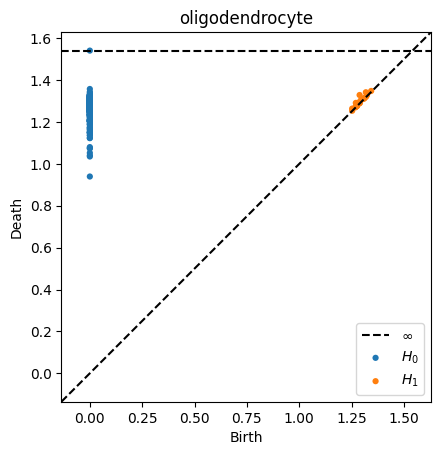

Processing cell type astrocyte.
----dataframe
----distance
----diagram


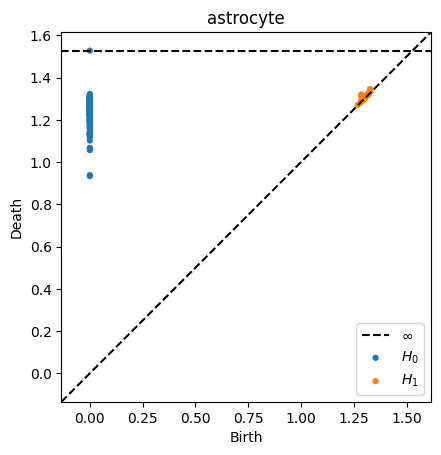

Processing cell type Bergmann glial cell.
----dataframe
----distance
----diagram


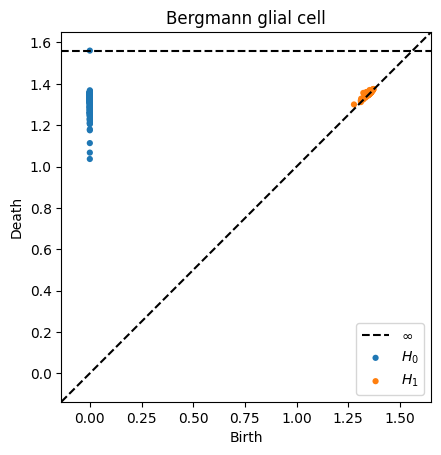

Processing cell type oligodendrocyte precursor cell.
----dataframe
----distance
----diagram


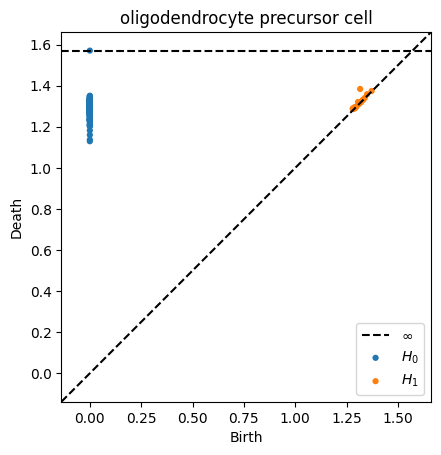

Processing cell type ependymal cell.
----dataframe
----distance
----diagram


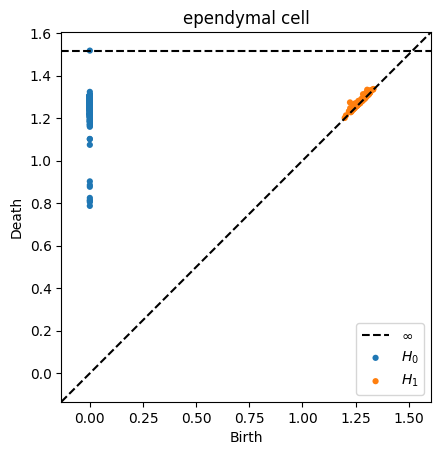

Processing cell type choroid plexus epithelial cell.
----dataframe
----distance
----diagram


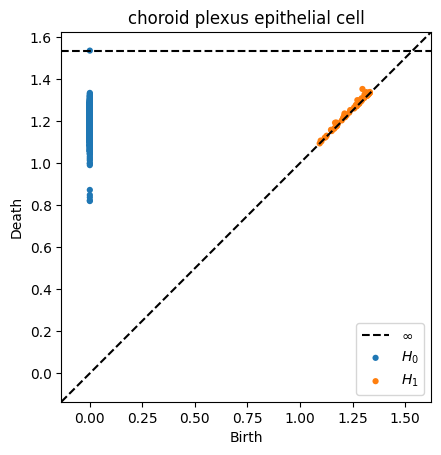

Processing cell type fibroblast.
----dataframe
----distance
----diagram


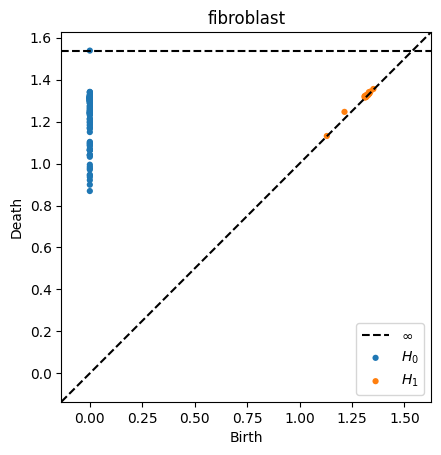

Processing cell type pericyte.
----dataframe
----distance
----diagram


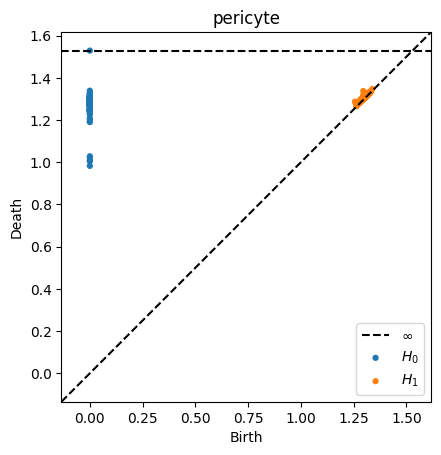

Processing cell type vascular associated smooth muscle cell.
----dataframe
----distance
----diagram


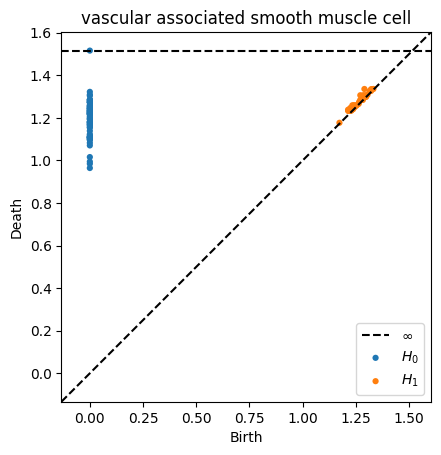

Processing cell type endothelial cell.
----dataframe
----distance
----diagram


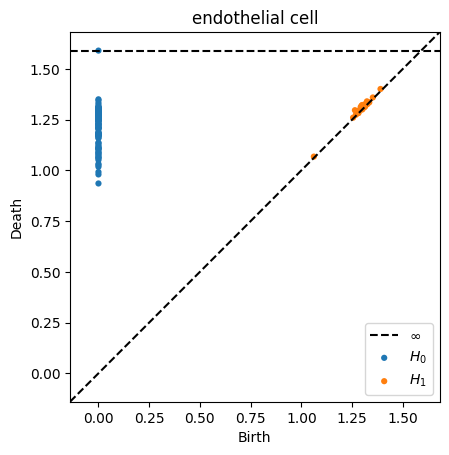

Processing cell type central nervous system macrophage.
----dataframe
----distance
----diagram


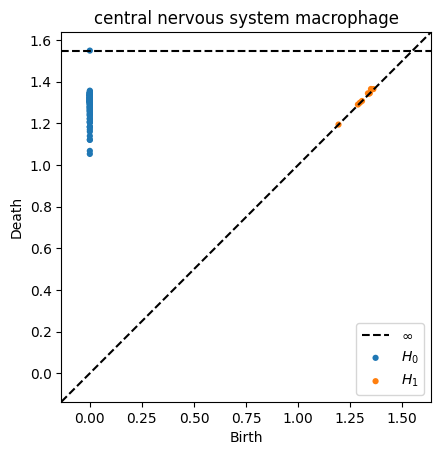

In [13]:
p_dgms = ds2dgm_multi(ds, cell_types, method='pearson', reduce=True, plot=True, dim_red=False, maxdim=1, preprocessing=False, variance=0.99)

## Bottleneck

### 0-dim

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

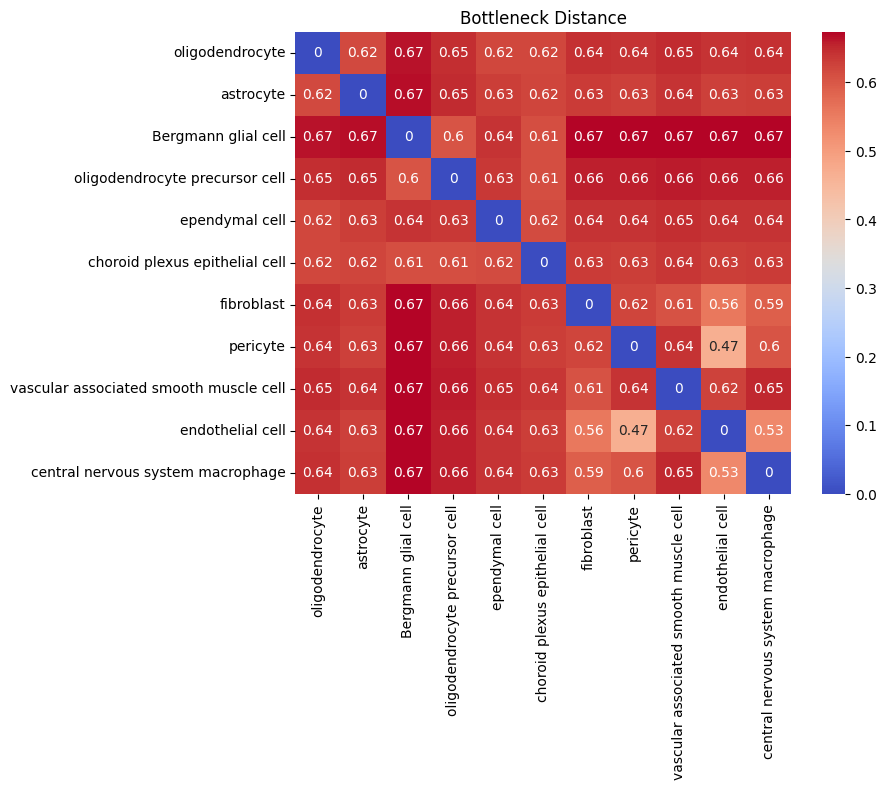

In [14]:
p_dist_0 = bottleneck_dist_mtrx(p_dgms, cell_types, dim=0)

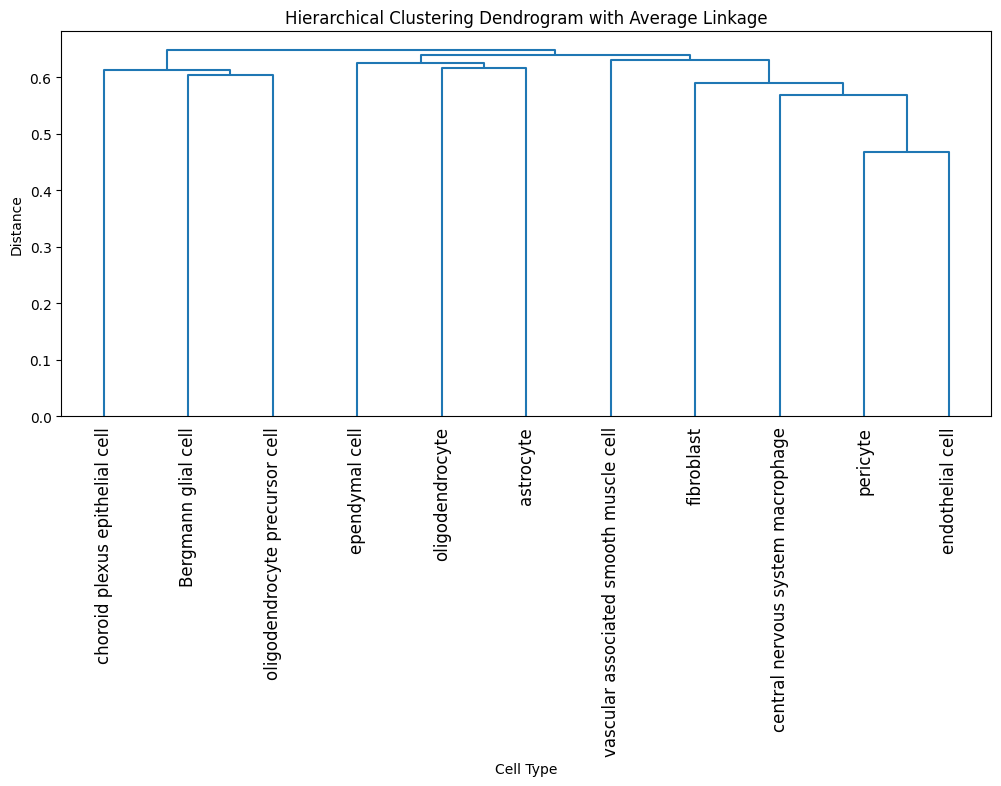

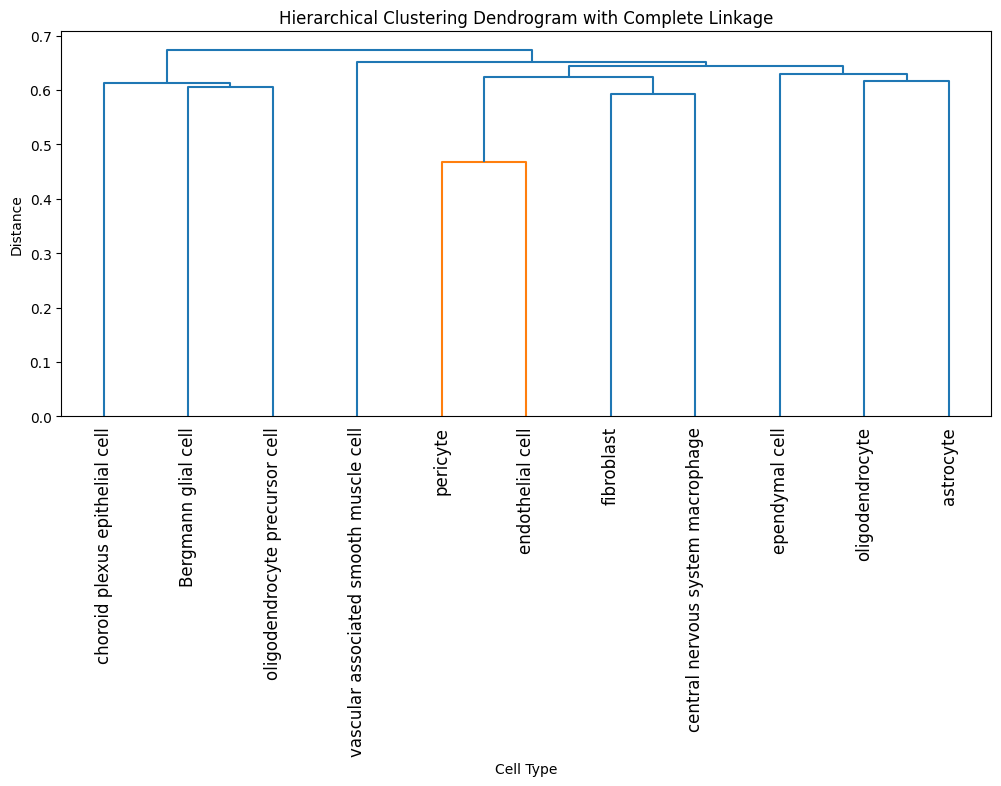

In [15]:
plot_dendrogram(p_dist_0, cell_types, method='average')
plot_dendrogram(p_dist_0, cell_types, method='complete')

### 1-dim

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

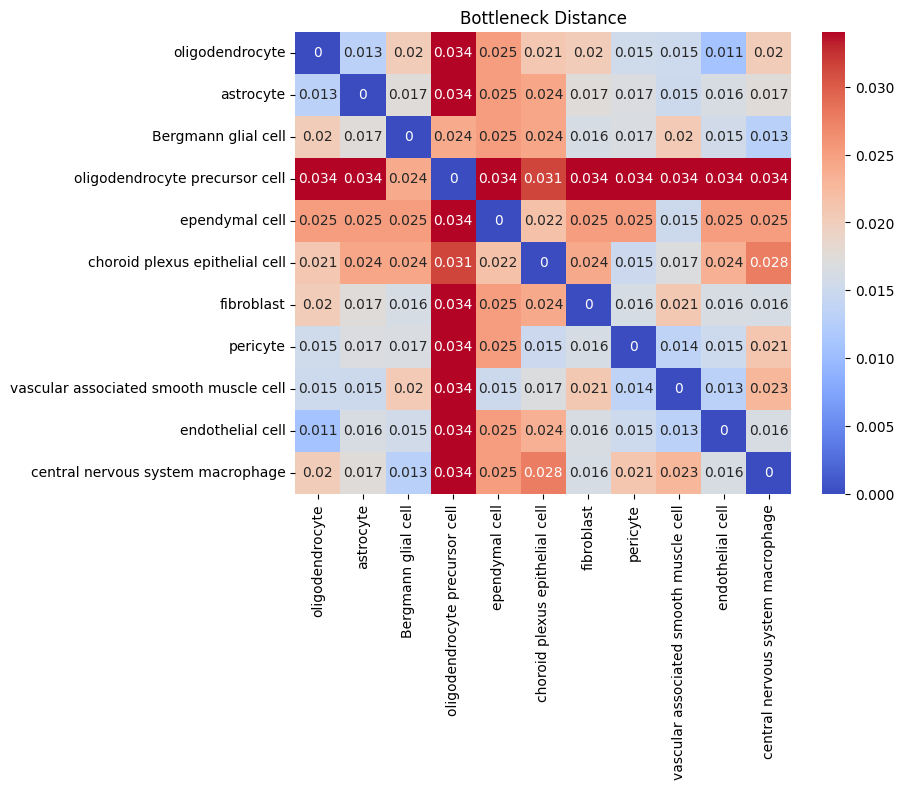

In [16]:
p_dist_1 = bottleneck_dist_mtrx(p_dgms, cell_types, dim=1)

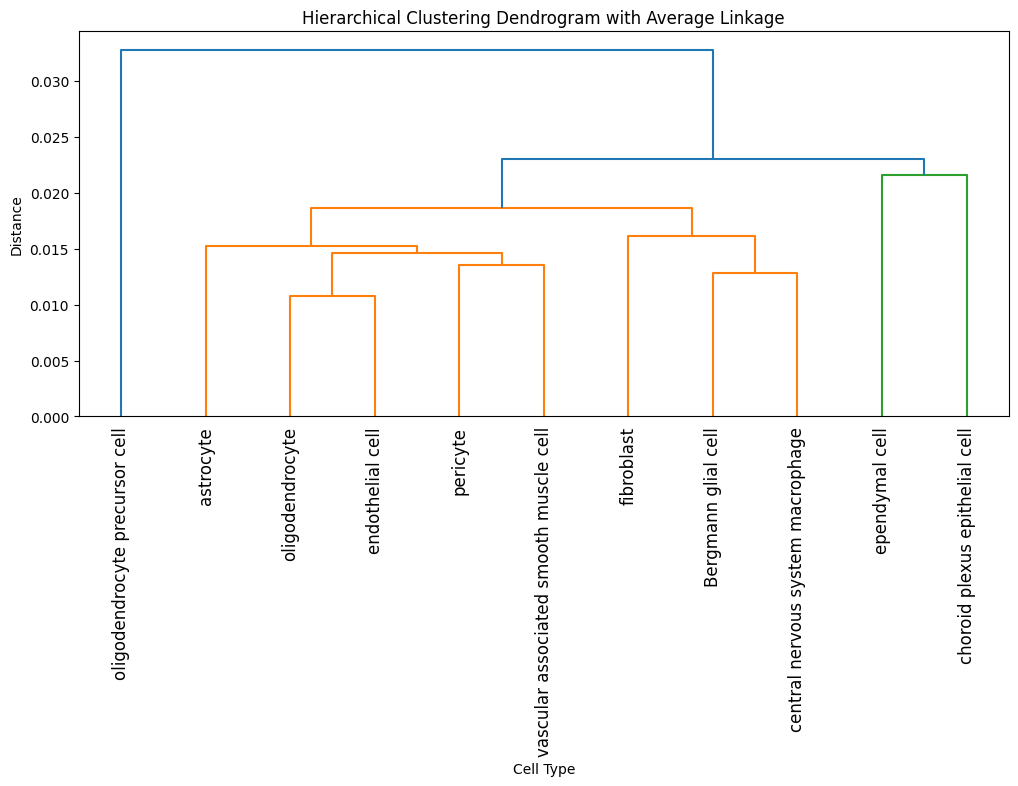

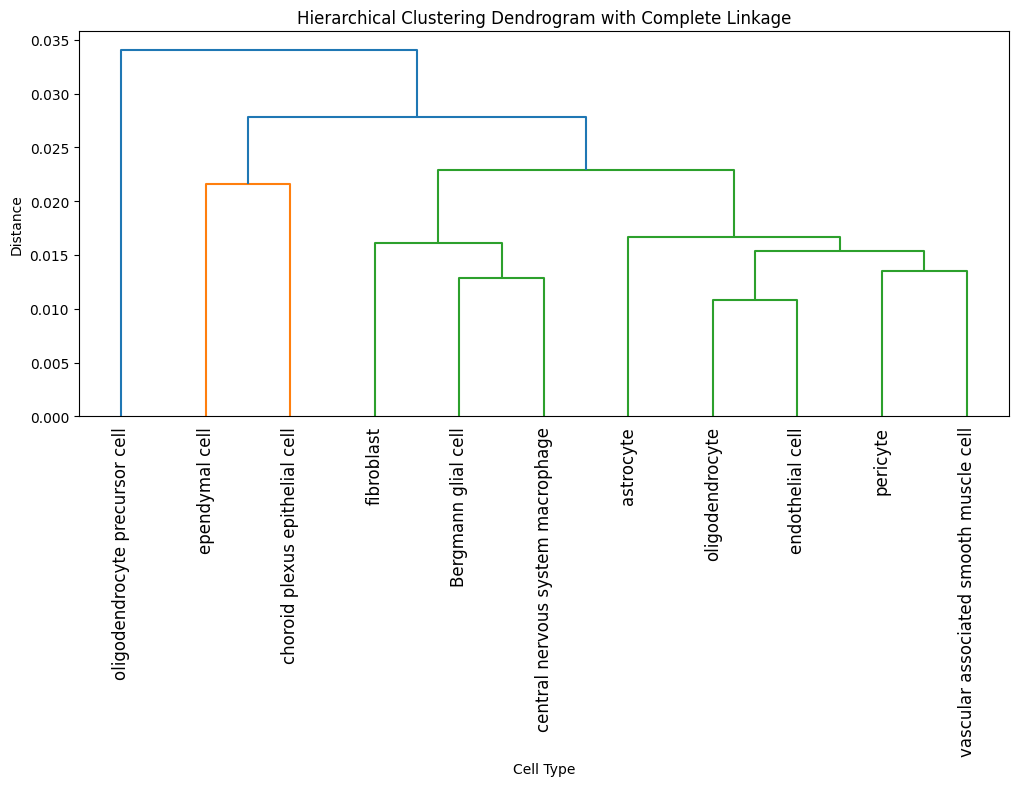

In [17]:
plot_dendrogram(p_dist_1, cell_types, method='average')
plot_dendrogram(p_dist_1, cell_types, method='complete')

### Both-dim

In [18]:
p_dist_0_norm = p_dist_0 / np.linalg.norm(p_dist_0, keepdims=True)
p_dist_1_norm = p_dist_1 / np.linalg.norm(p_dist_1, keepdims=True)

p_dist_both = p_dist_0_norm + p_dist_1_norm

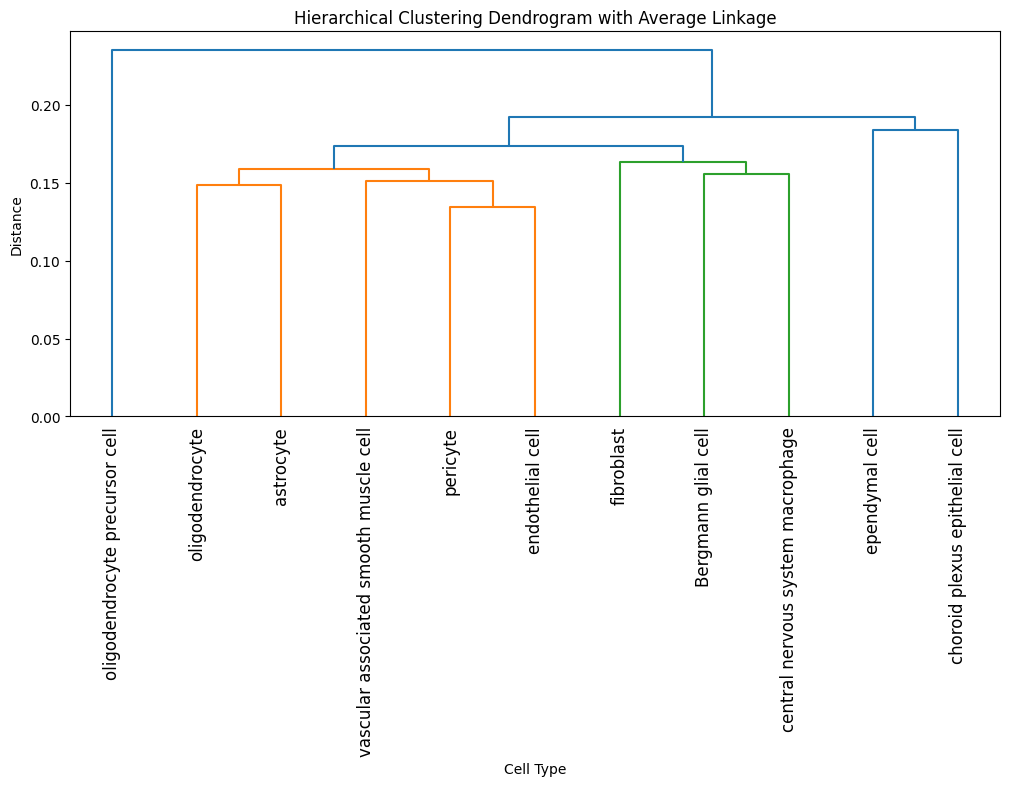

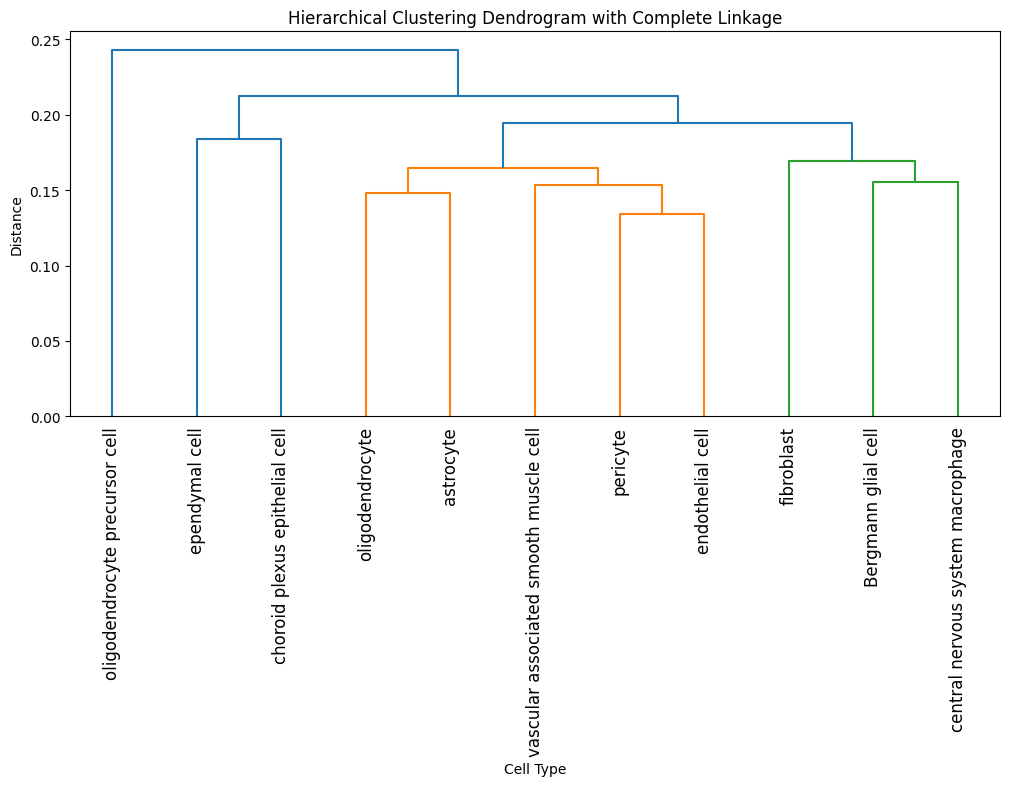

In [19]:
plot_dendrogram(p_dist_both, cell_types, method='average')
plot_dendrogram(p_dist_both, cell_types, method='complete')

## Persistence Image

### Padding

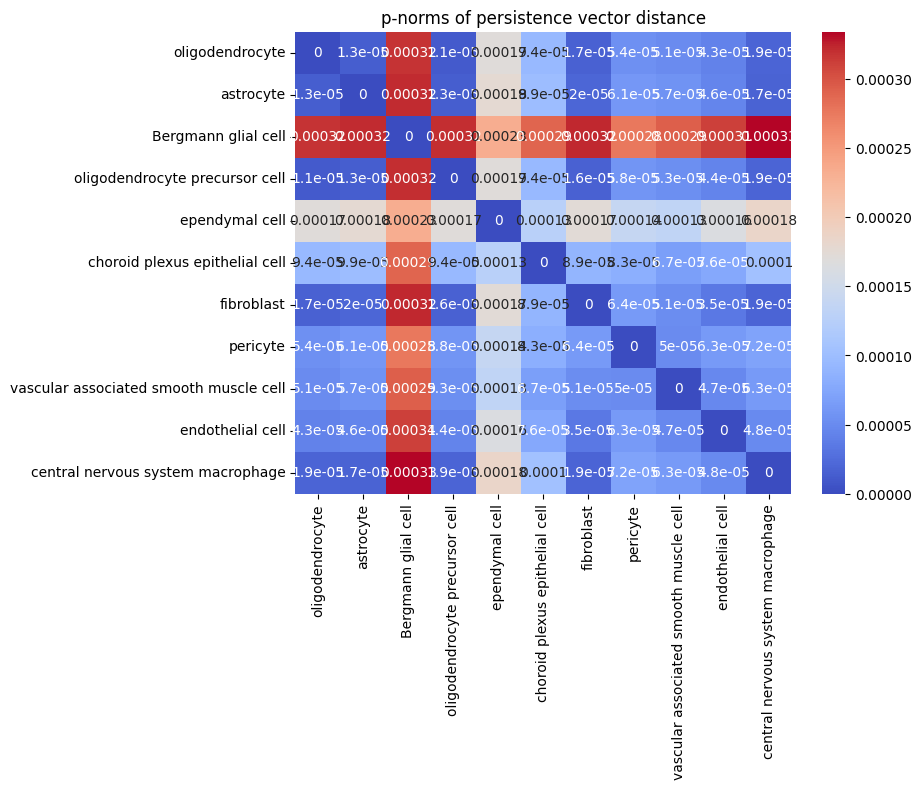

In [20]:
p_imgs_pad, p_imgs_pad_valid_types = persistence_img_resize(p_dgms, cell_types, new_shape=(10, 3), padding=True)
p_norms_pad = persistence_img_norms(p_imgs_pad, p_imgs_pad_valid_types, p=2, plot=True);

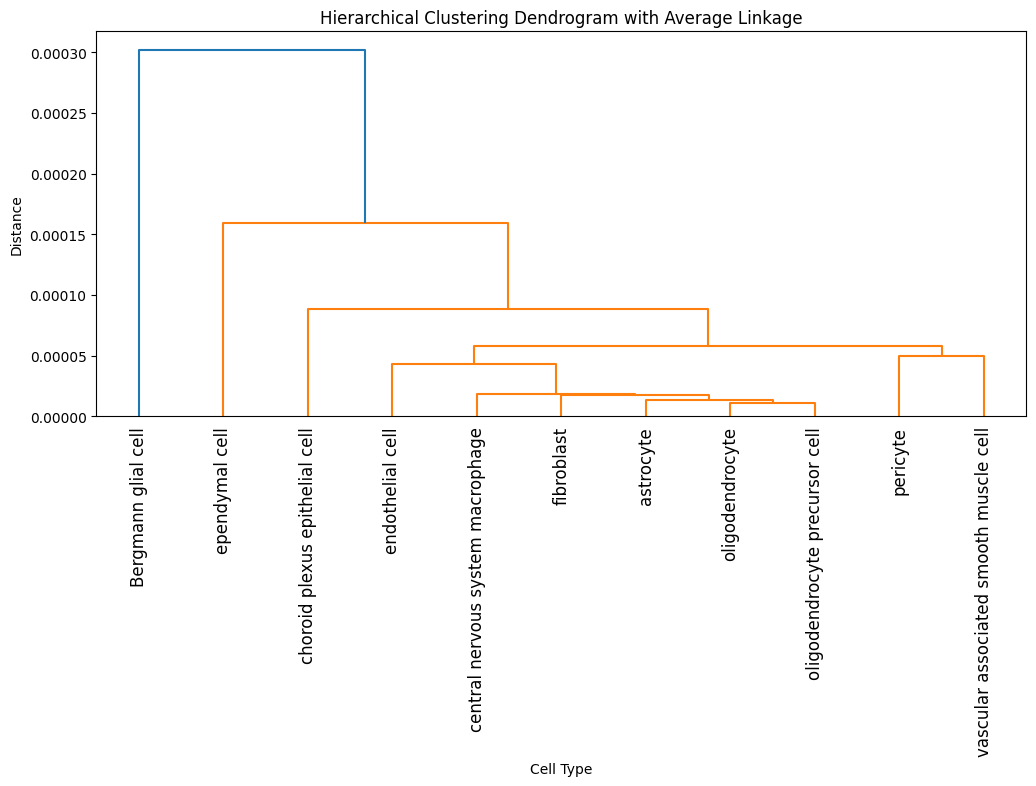

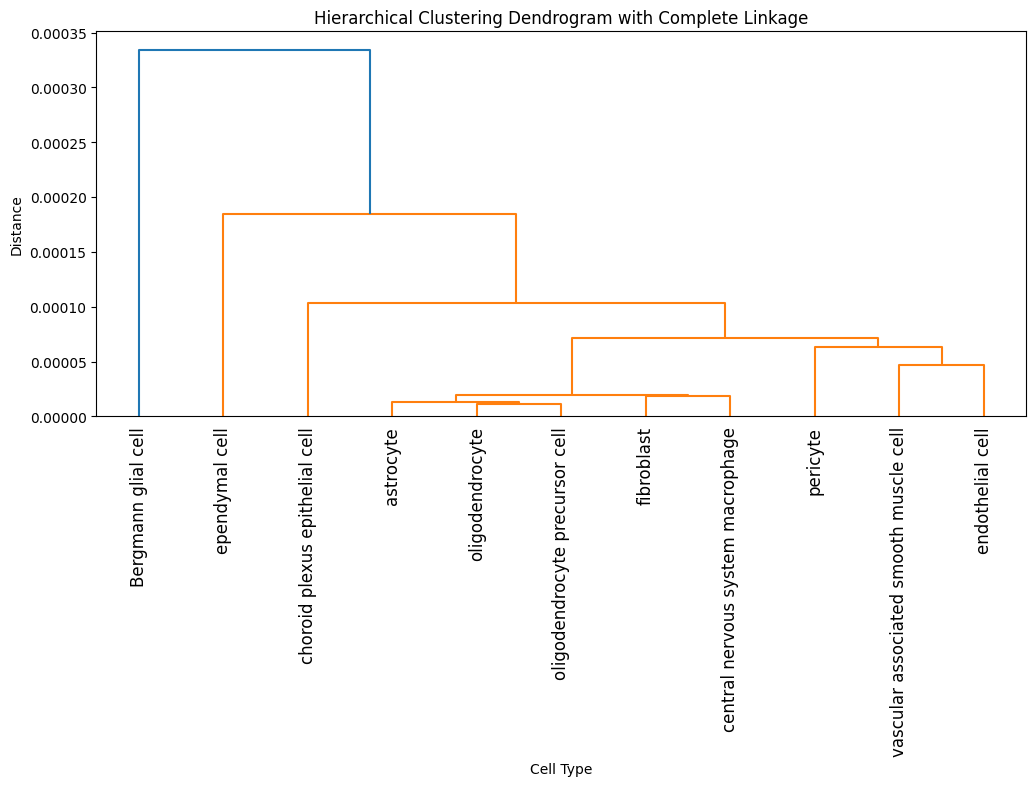

In [21]:
plot_dendrogram(p_norms_pad, p_imgs_pad_valid_types, method='average')
plot_dendrogram(p_norms_pad, p_imgs_pad_valid_types, method='complete')

### Resize

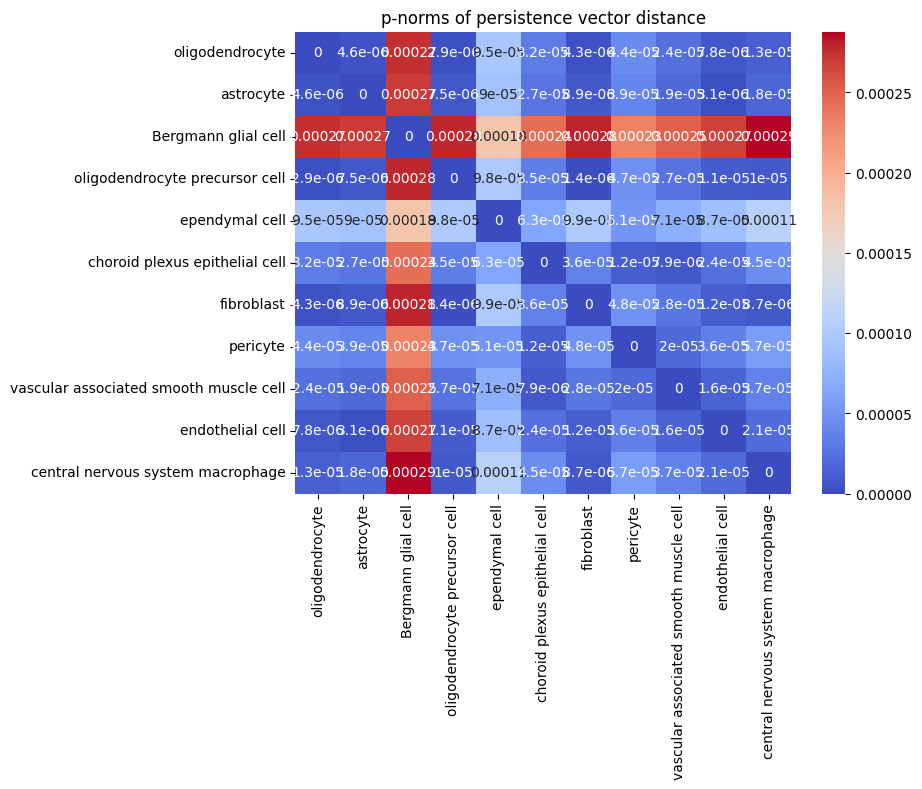

In [22]:
p_imgs_resize, p_imgs_resize_valid_types = persistence_img_resize(p_dgms, cell_types, new_shape=(10, 3), padding=False)
p_norms_resize = persistence_img_norms(p_imgs_resize, p_imgs_resize_valid_types, p=2, plot=True);

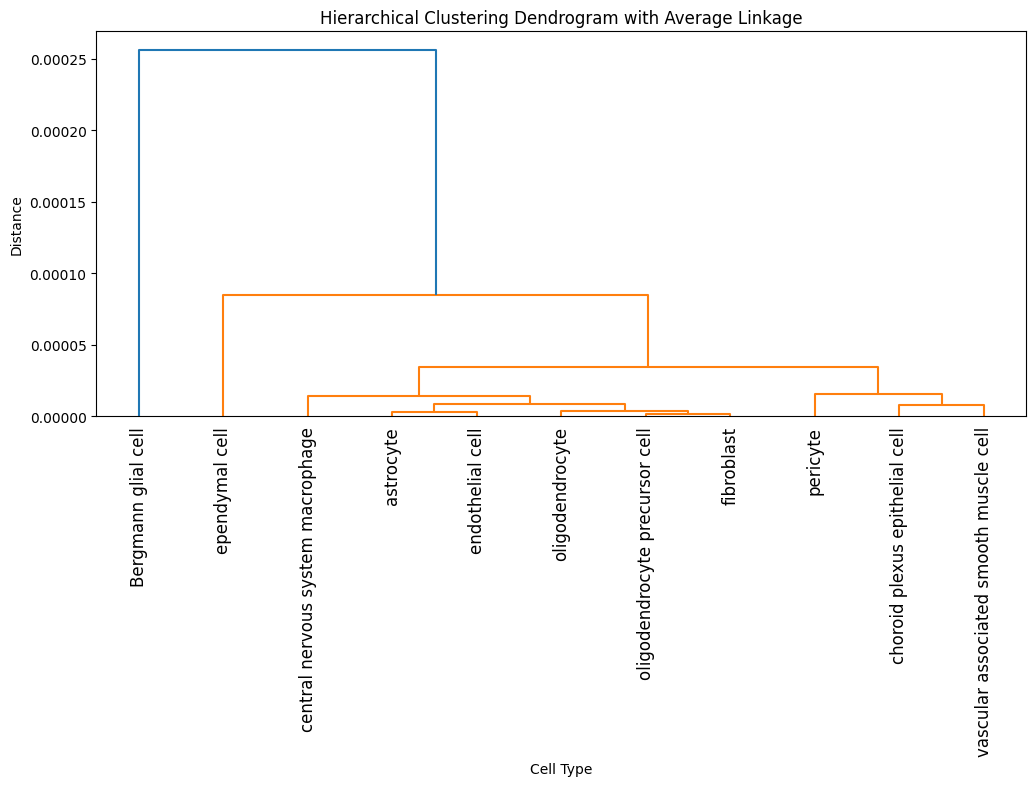

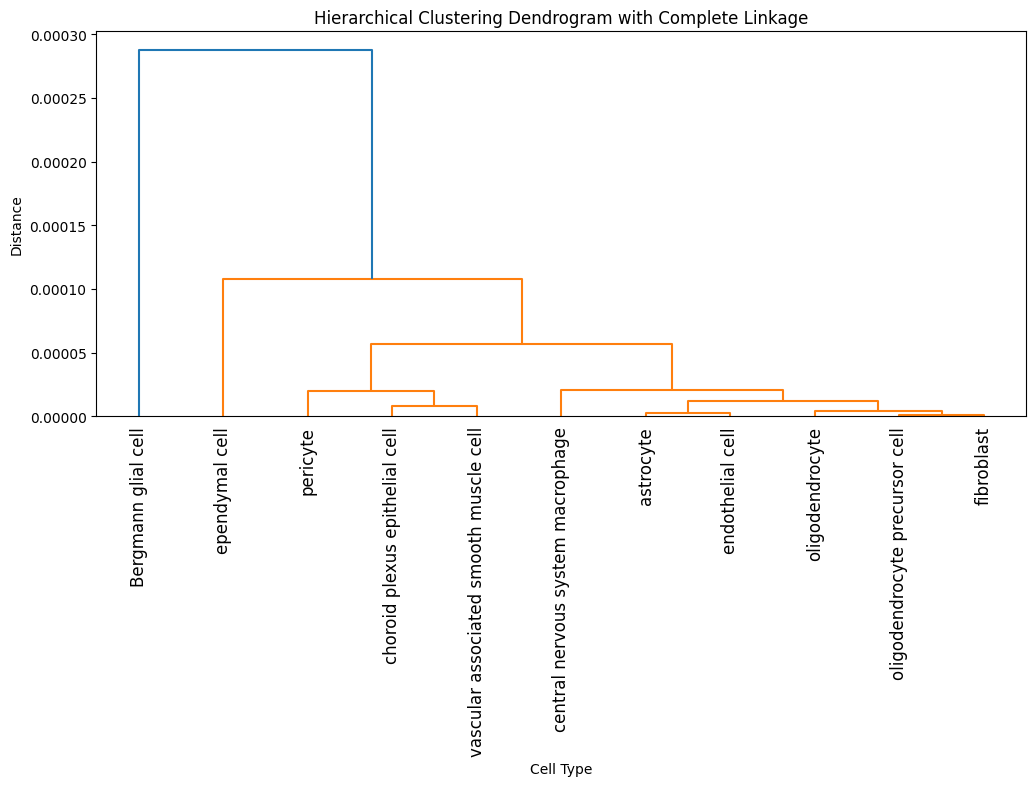

In [23]:
plot_dendrogram(p_norms_resize, p_imgs_resize_valid_types, method='average')
plot_dendrogram(p_norms_resize, p_imgs_resize_valid_types, method='complete')

# Euclidean

  0%|          | 0/11 [00:00<?, ?it/s]

Processing cell type oligodendrocyte.
----dataframe
----distance
----diagram


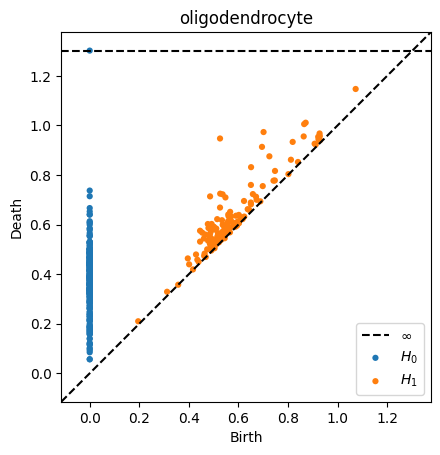

Processing cell type astrocyte.
----dataframe
----distance
----diagram


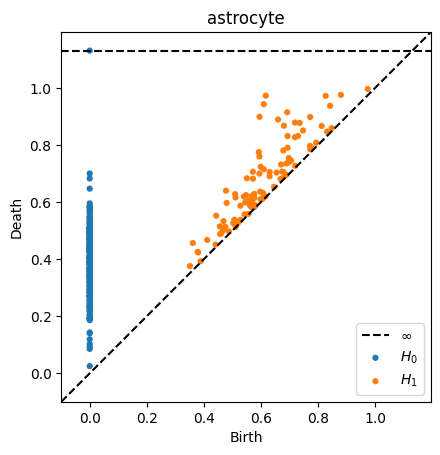

Processing cell type Bergmann glial cell.
----dataframe
----distance
----diagram


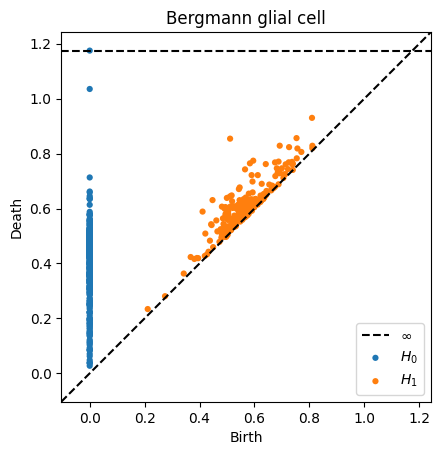

Processing cell type oligodendrocyte precursor cell.
----dataframe
----distance
----diagram


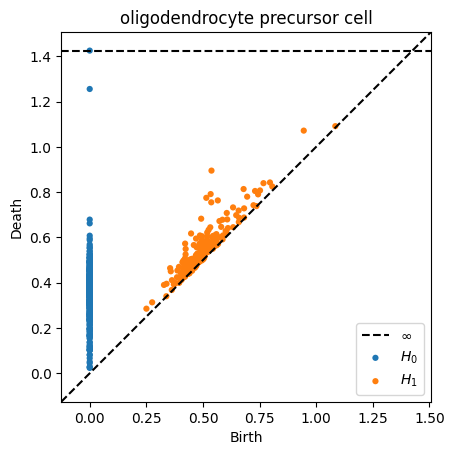

Processing cell type ependymal cell.
----dataframe
----distance
----diagram


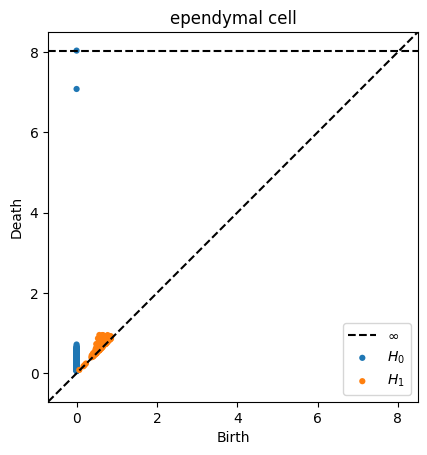

Processing cell type choroid plexus epithelial cell.
----dataframe
----distance
----diagram


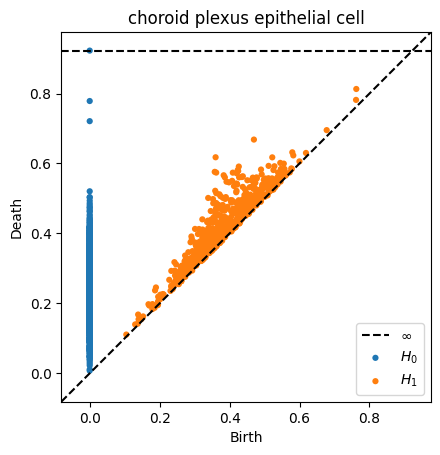

Processing cell type fibroblast.
----dataframe
----distance
----diagram


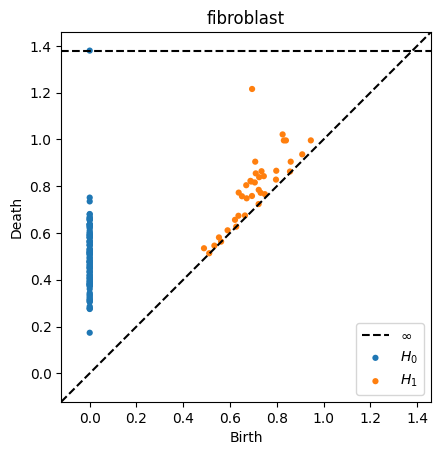

Processing cell type pericyte.
----dataframe
----distance
----diagram


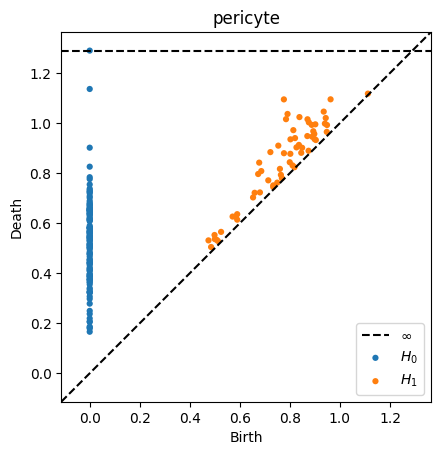

Processing cell type vascular associated smooth muscle cell.
----dataframe
----distance
----diagram


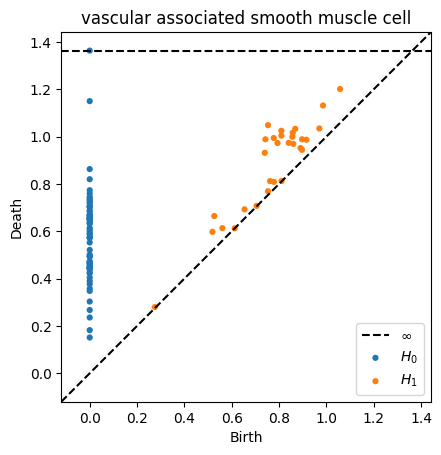

Processing cell type endothelial cell.
----dataframe
----distance
----diagram


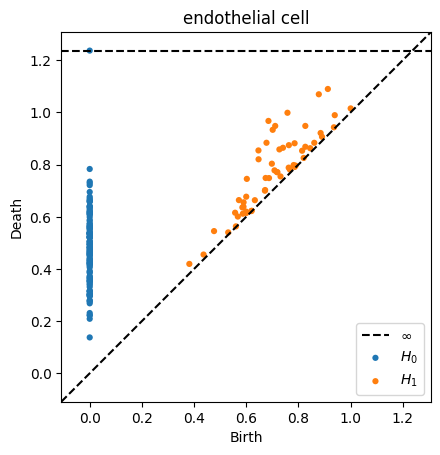

Processing cell type central nervous system macrophage.
----dataframe
----distance
----diagram


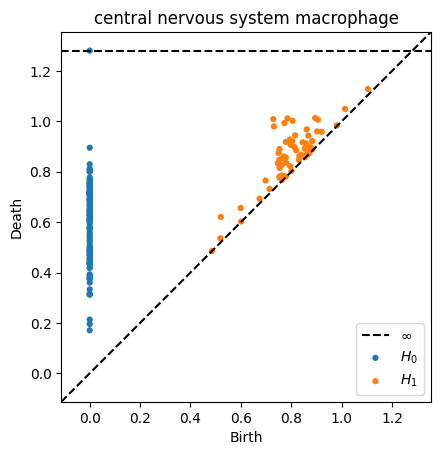

In [24]:
e_dgms = ds2dgm_multi(ds, cell_types, method='euclidean', reduce=True, plot=True, dim_red=True, maxdim=1, preprocessing=True, variance=0.99)

## Bottleneck

### 0-dim

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

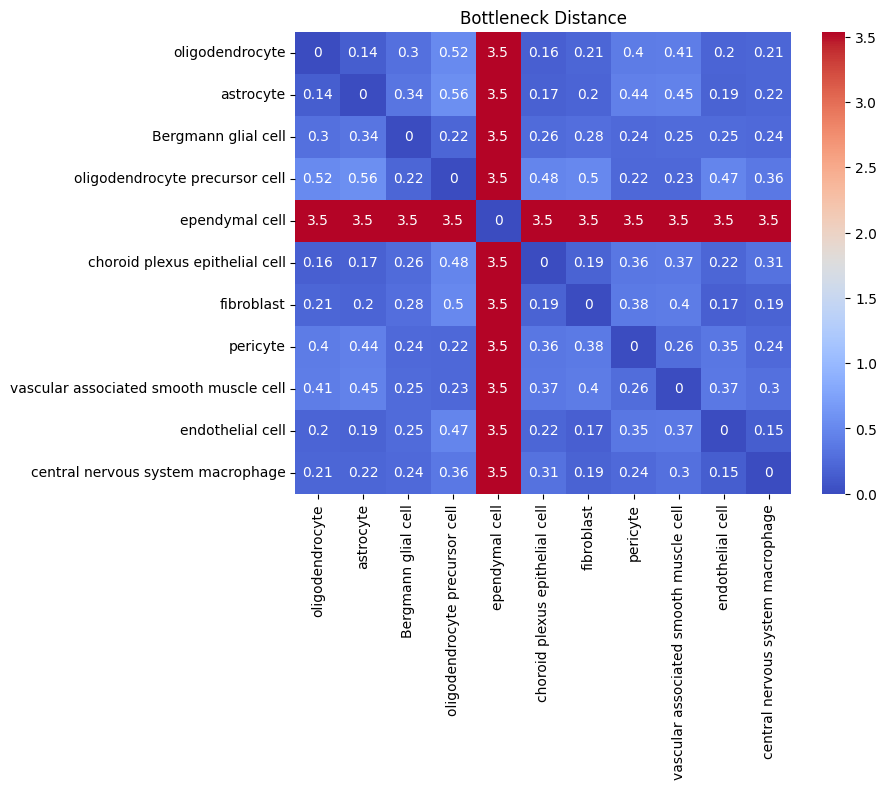

In [25]:
e_dist_0 = bottleneck_dist_mtrx(e_dgms, cell_types, dim=0)

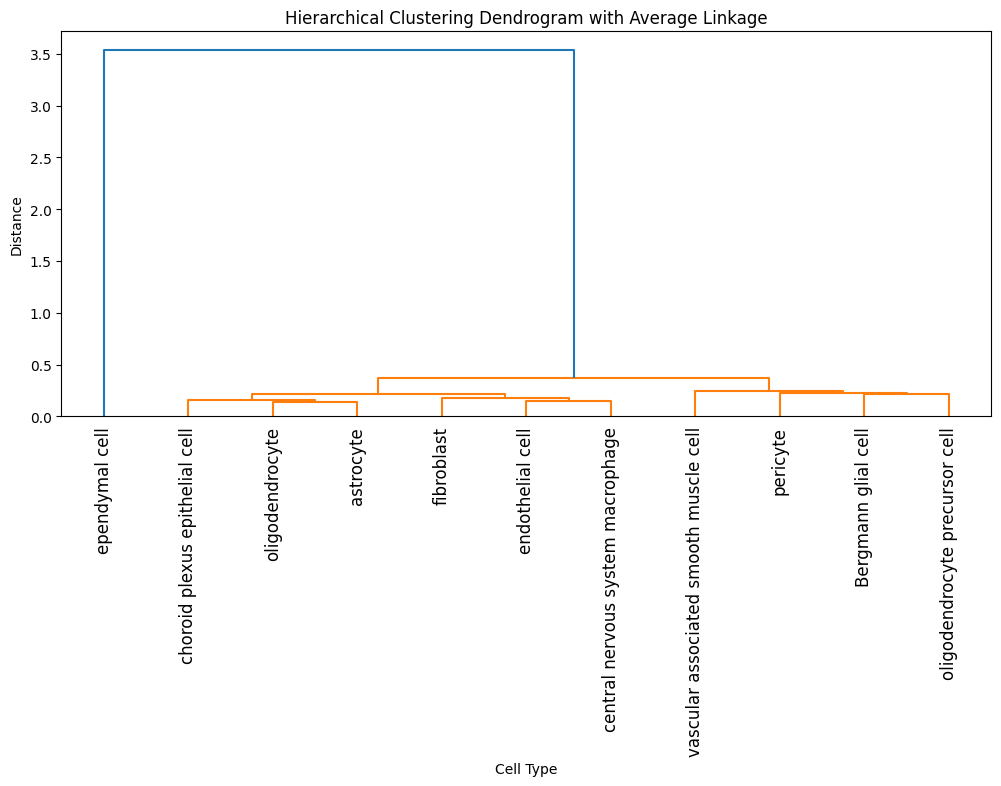

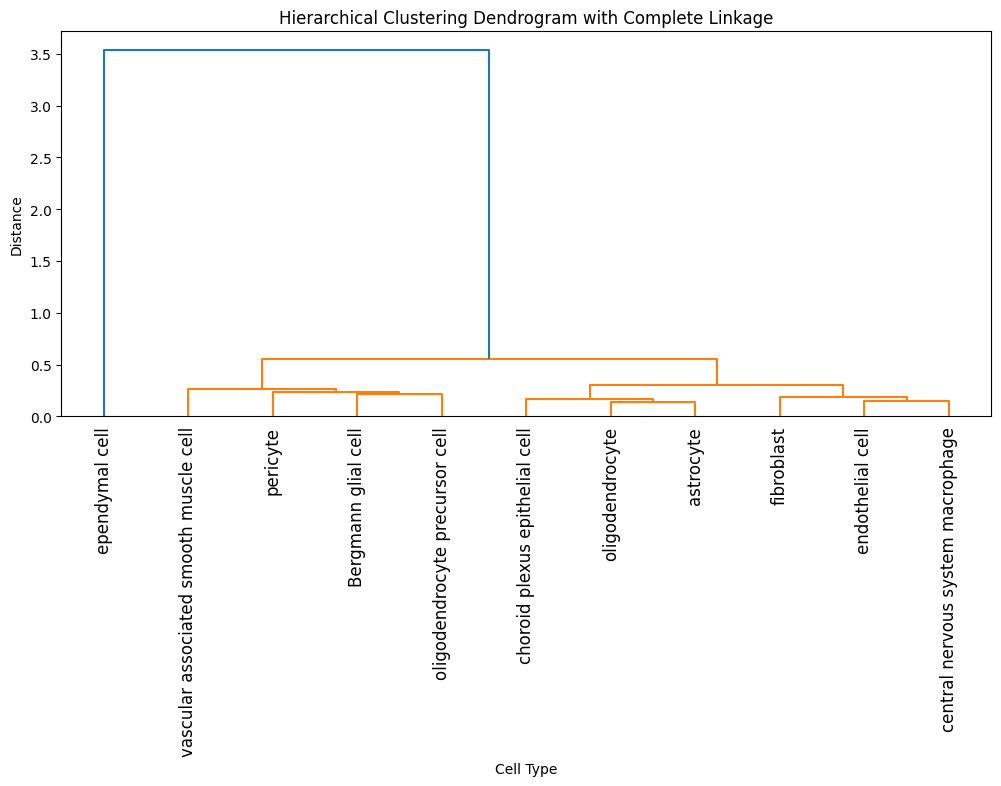

In [26]:
plot_dendrogram(e_dist_0, cell_types, method='average')
plot_dendrogram(e_dist_0, cell_types, method='complete')

### 1-dim

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

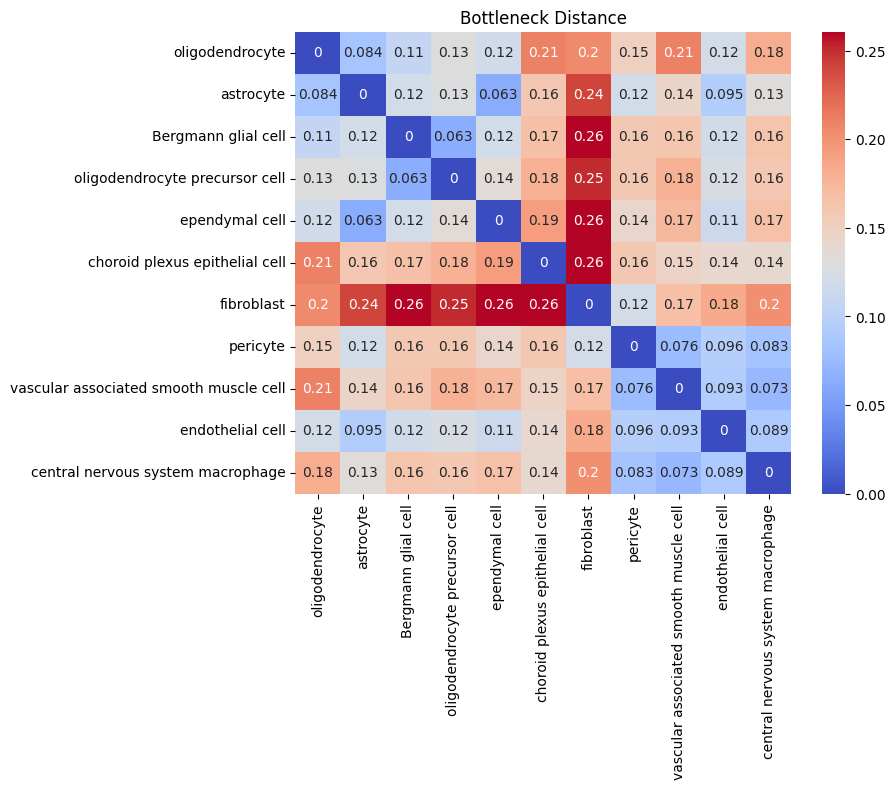

In [27]:
e_dist_1 = bottleneck_dist_mtrx(e_dgms, cell_types, dim=1)

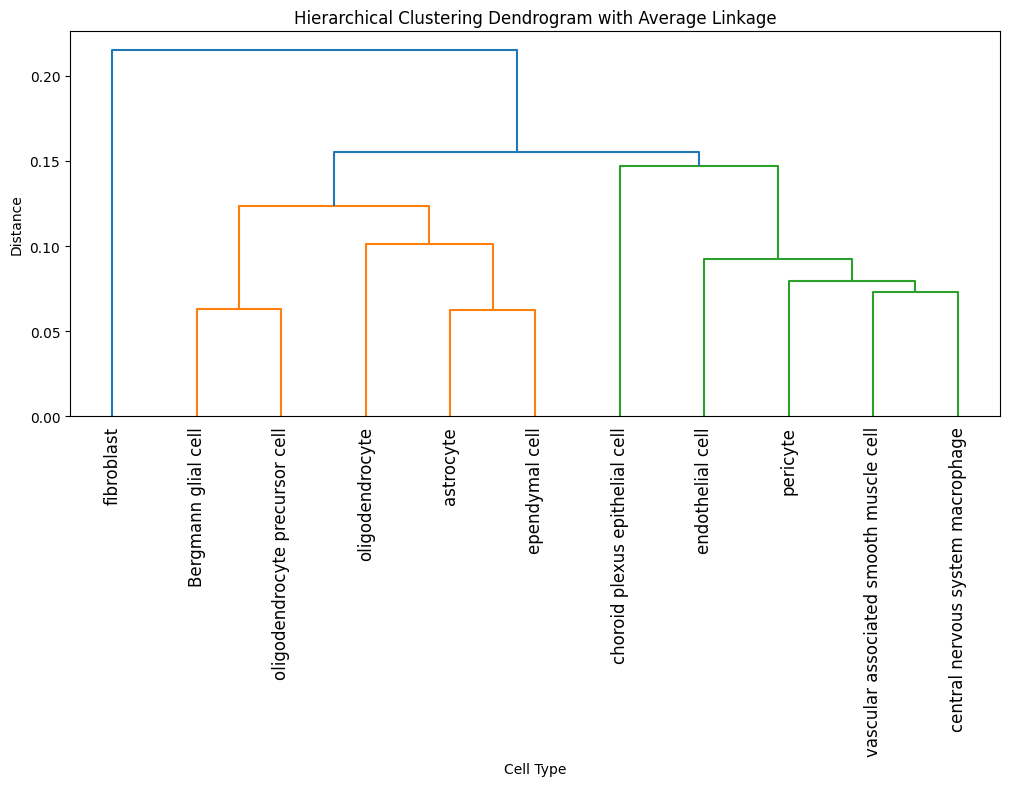

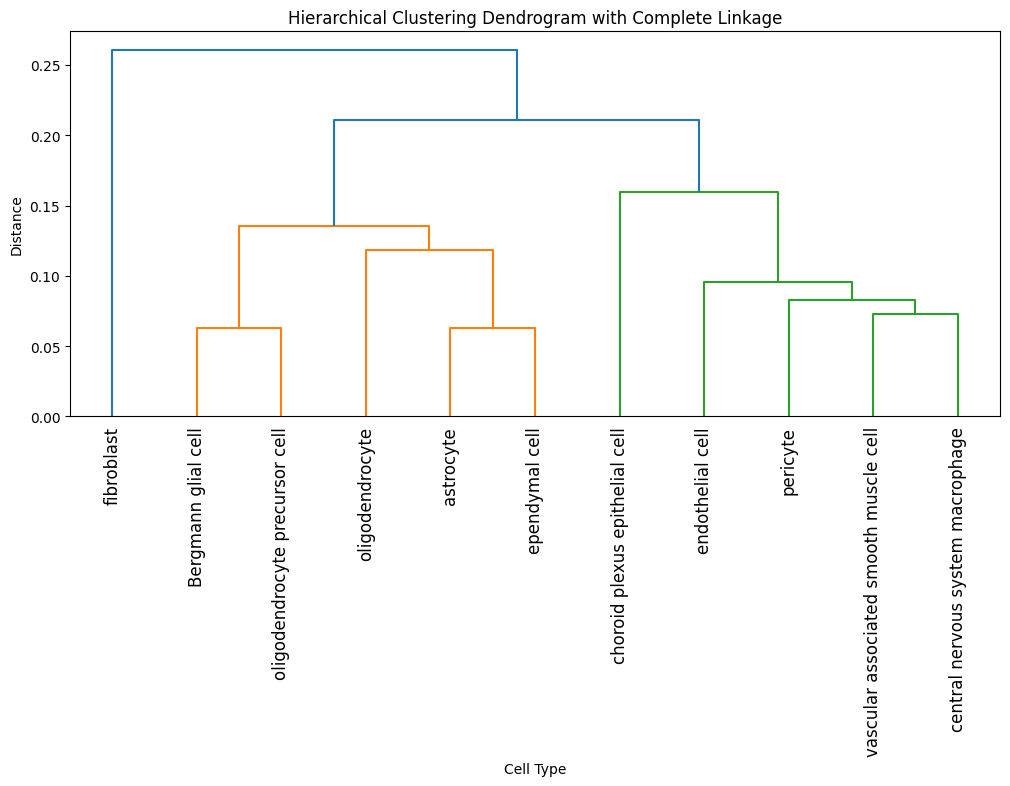

In [28]:
plot_dendrogram(e_dist_1, cell_types, method='average')
plot_dendrogram(e_dist_1, cell_types, method='complete')

### Both-dim

In [29]:
e_dist_0_norm = e_dist_0 / np.linalg.norm(e_dist_0, keepdims=True)
e_dist_1_norm = e_dist_1 / np.linalg.norm(e_dist_1, keepdims=True)

e_dist_both = e_dist_0_norm + e_dist_1_norm

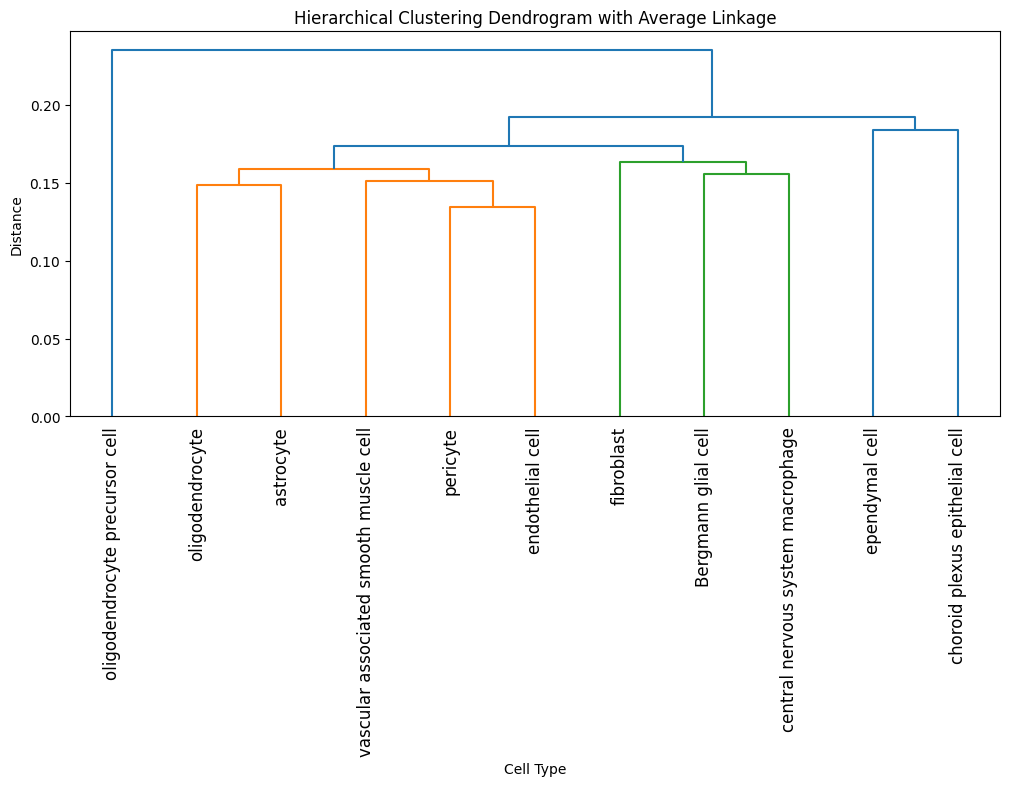

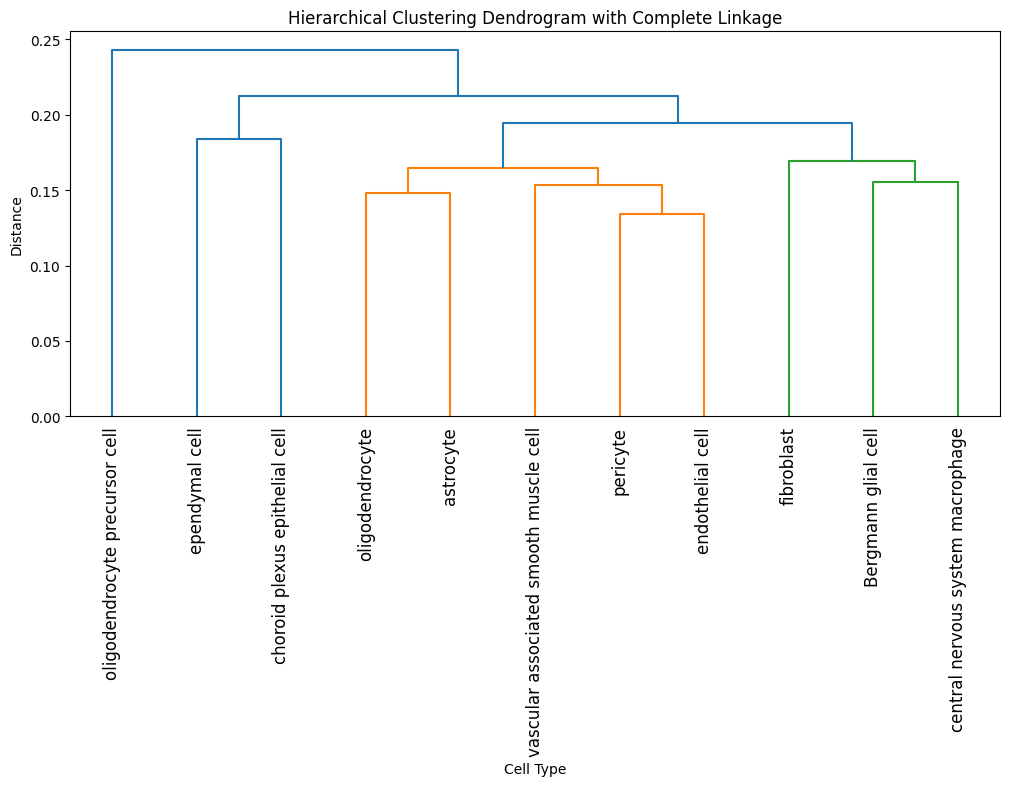

In [30]:
plot_dendrogram(p_dist_both, cell_types, method='average')
plot_dendrogram(p_dist_both, cell_types, method='complete')

## Persistence Image

### Padding

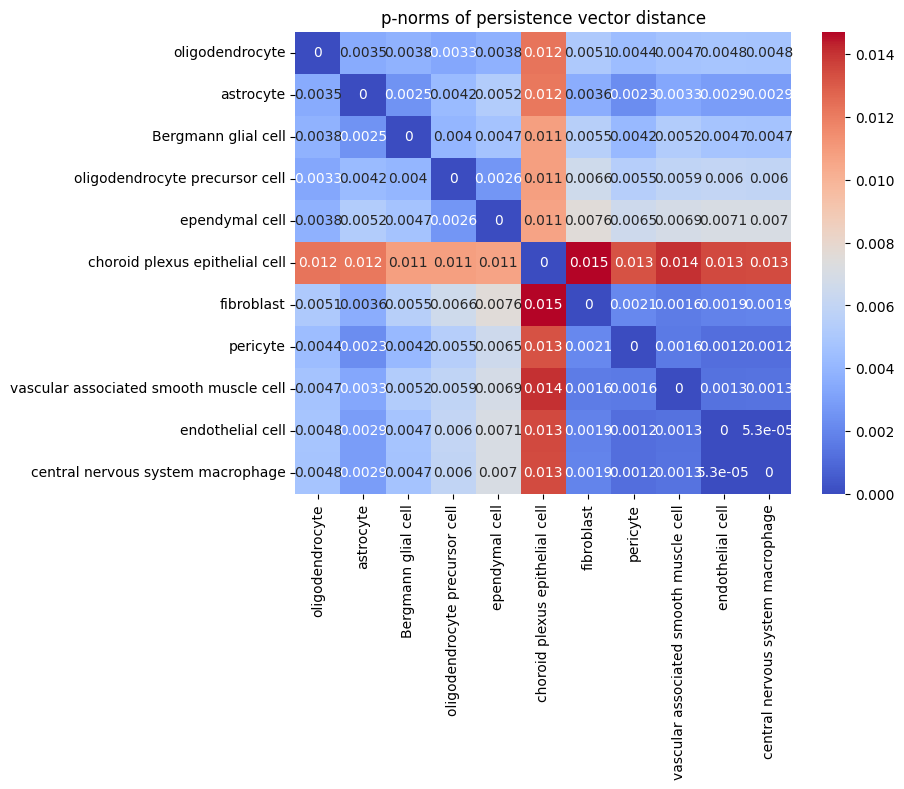

In [31]:
e_imgs_pad, e_imgs_pad_valid_types = persistence_img_resize(e_dgms, cell_types, new_shape=(10, 3), padding=True)
e_norms_pad = persistence_img_norms(e_imgs_pad, e_imgs_pad_valid_types, p=2, plot=True);

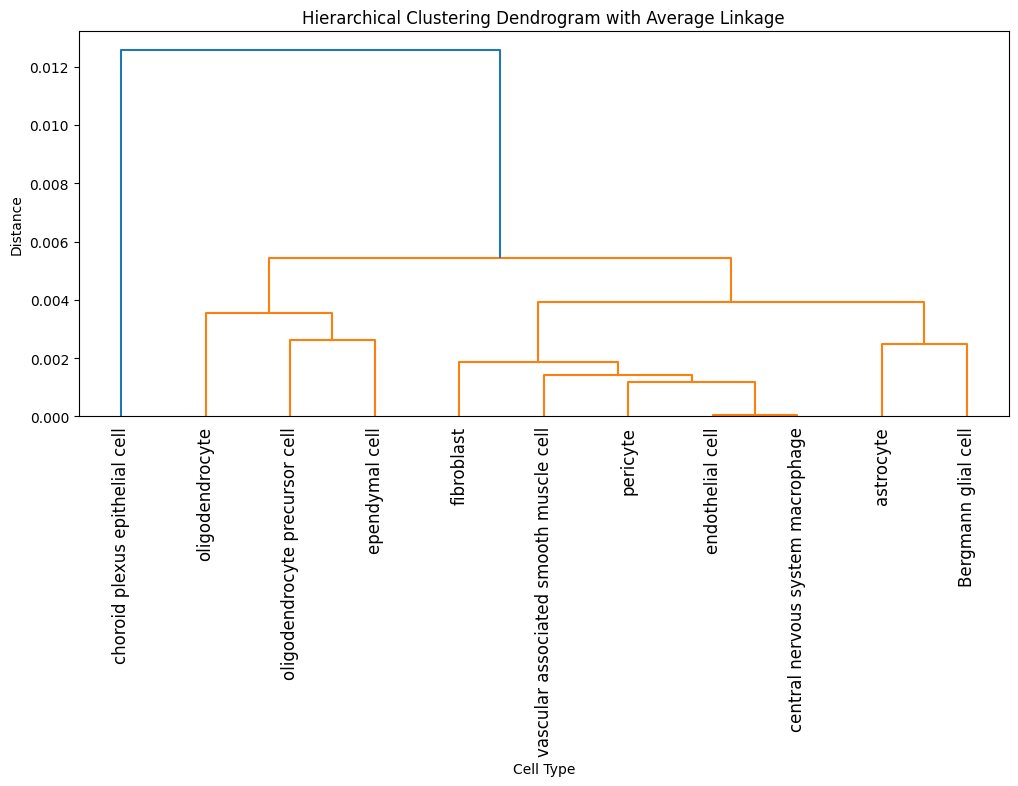

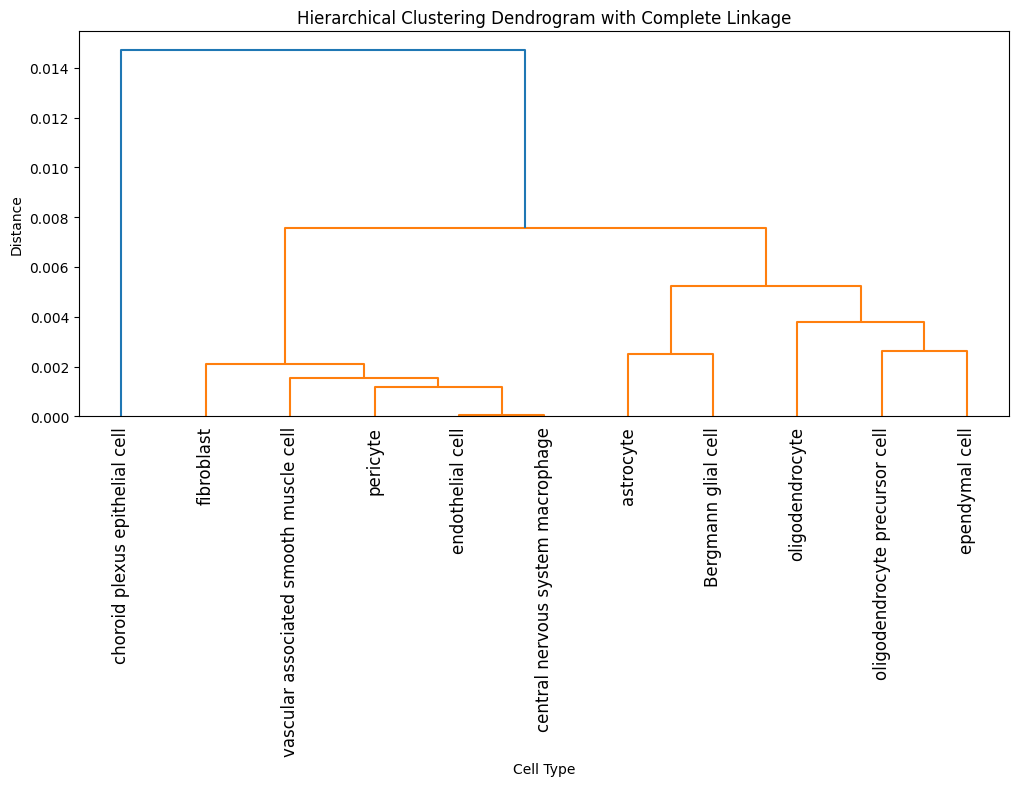

In [32]:
plot_dendrogram(e_norms_pad, e_imgs_pad_valid_types, method='average')
plot_dendrogram(e_norms_pad, e_imgs_pad_valid_types, method='complete')

### Resize

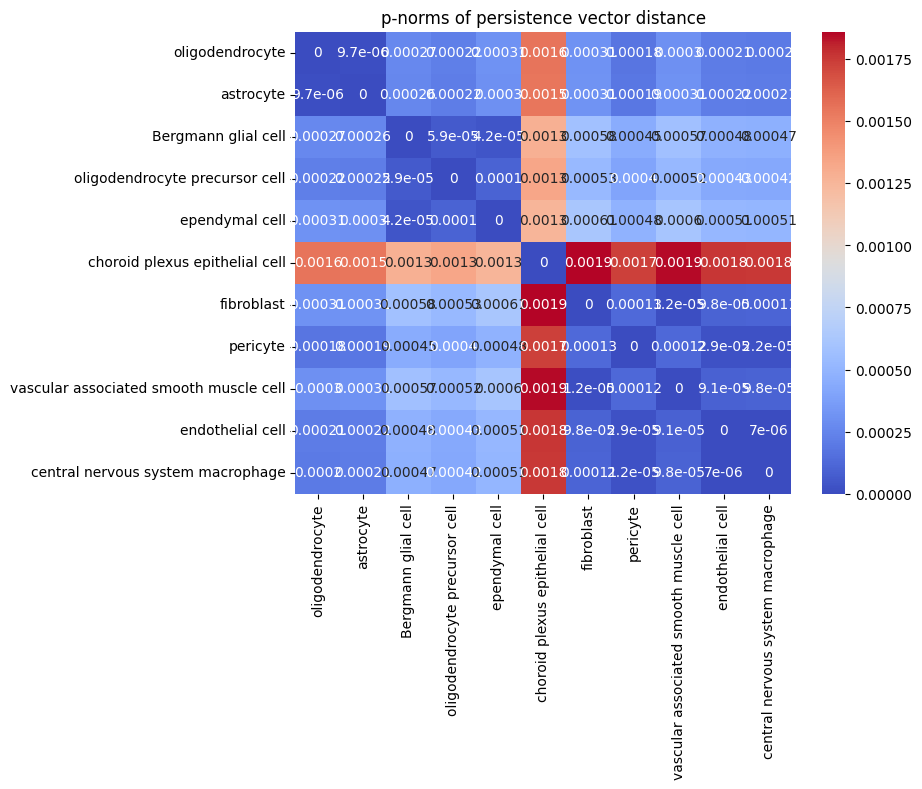

In [33]:
e_imgs_resize, e_imgs_resize_valid_types = persistence_img_resize(e_dgms, cell_types, new_shape=(10, 3), padding=False)
e_norms_resize = persistence_img_norms(e_imgs_resize, e_imgs_resize_valid_types, p=2, plot=True);

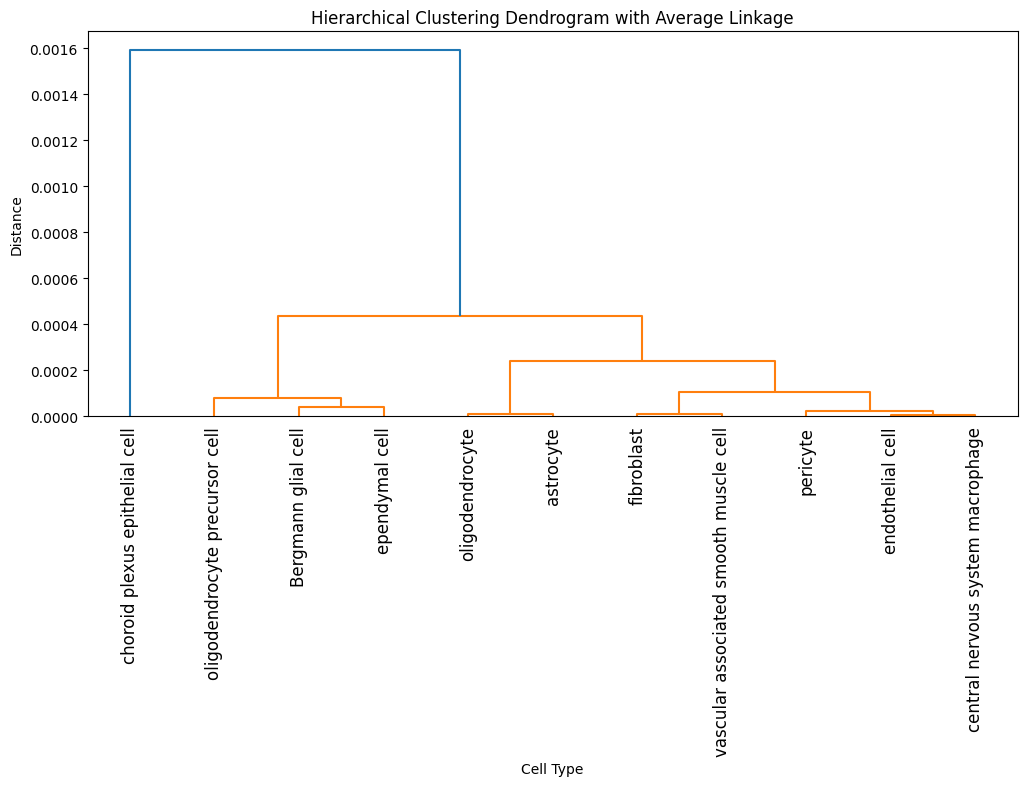

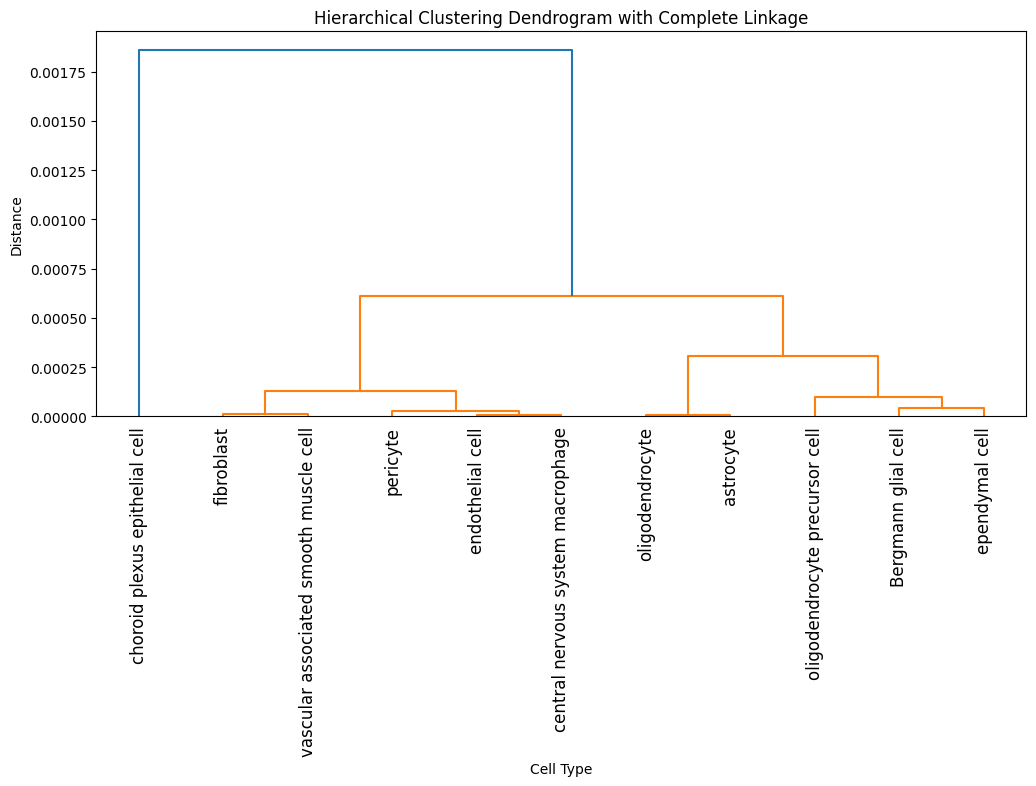

In [34]:
plot_dendrogram(e_norms_resize, e_imgs_resize_valid_types, method='average')
plot_dendrogram(e_norms_resize, e_imgs_resize_valid_types, method='complete')

# Consensus Hierarchical Clustering

## Pearson

In [49]:
p_dist_arr = np.array([p_dist_both, p_norms_pad])
p_dist_agg = np.sum(np.stack([dist/np.linalg.norm(dist, ord=2) for dist in p_dist_arr]), axis=0)

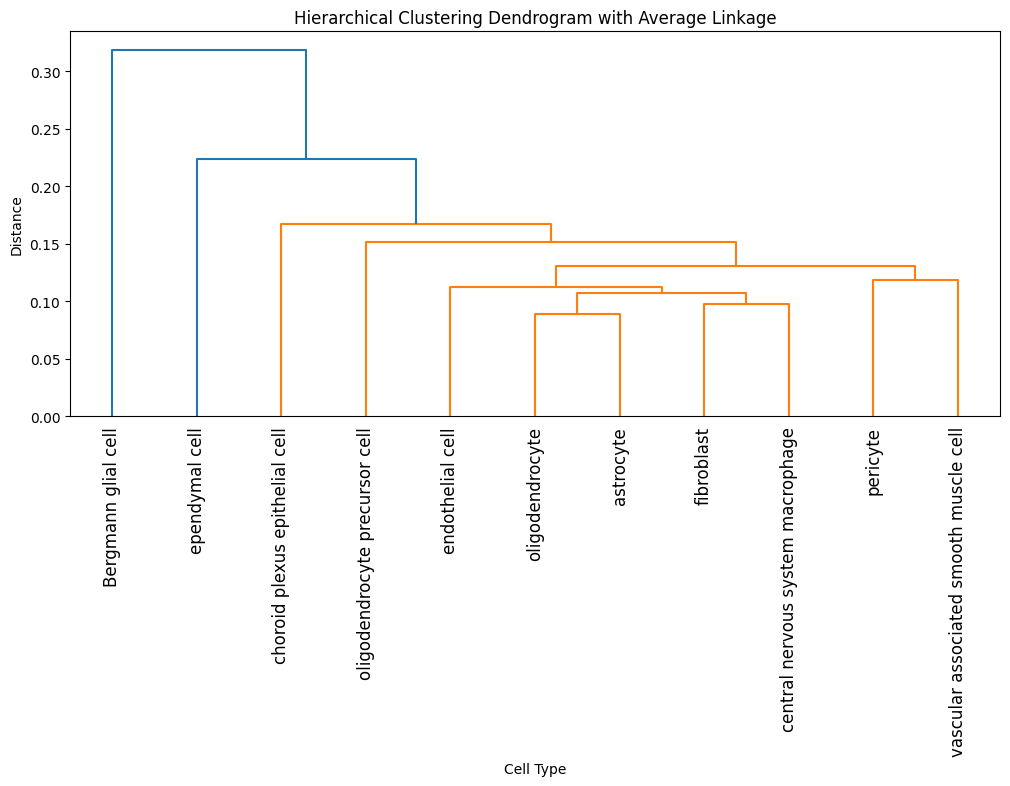

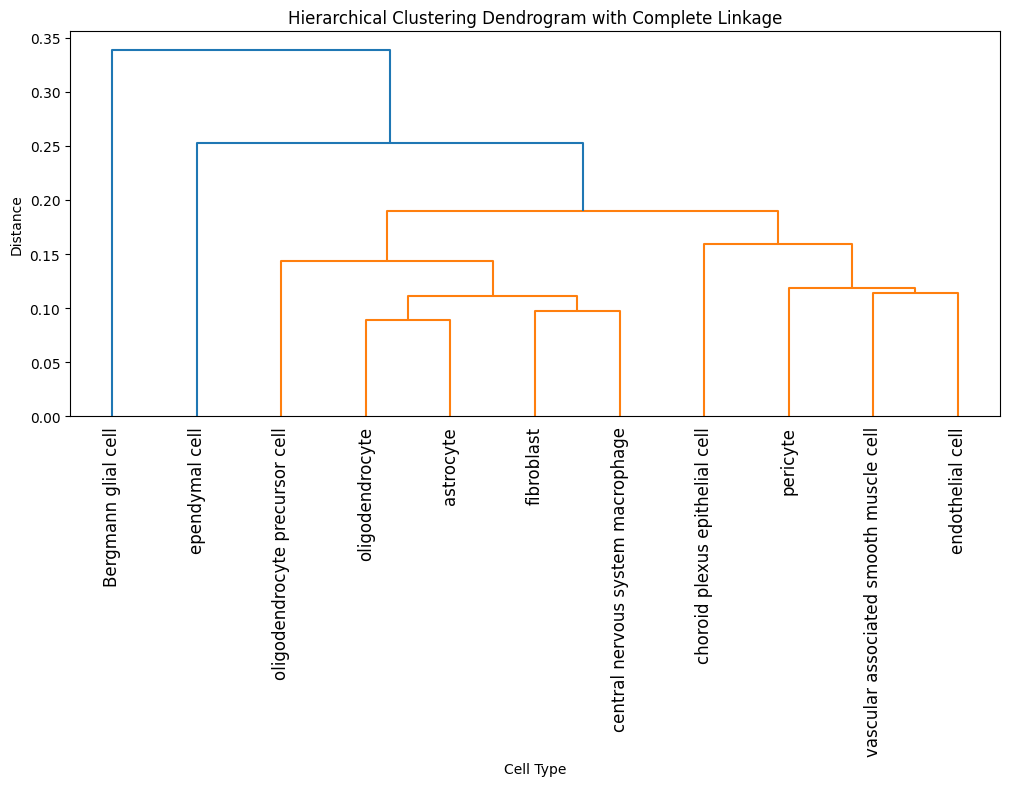

In [51]:
plot_dendrogram(p_dist_agg, cell_types, method='average')
plot_dendrogram(p_dist_agg, cell_types, method='complete')

## Euclidean

In [52]:
e_dist_arr = np.array([e_dist_both, e_norms_pad])
e_dist_agg = np.sum(np.stack([dist/np.linalg.norm(dist, ord=2) for dist in e_dist_arr]), axis=0)

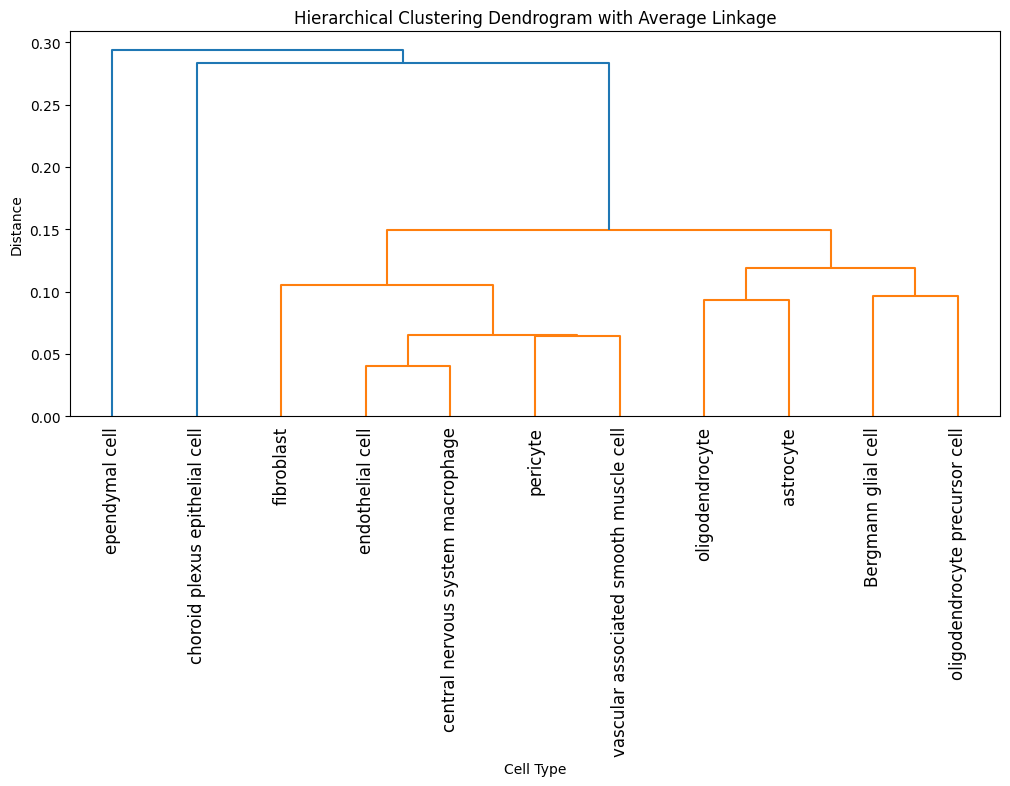

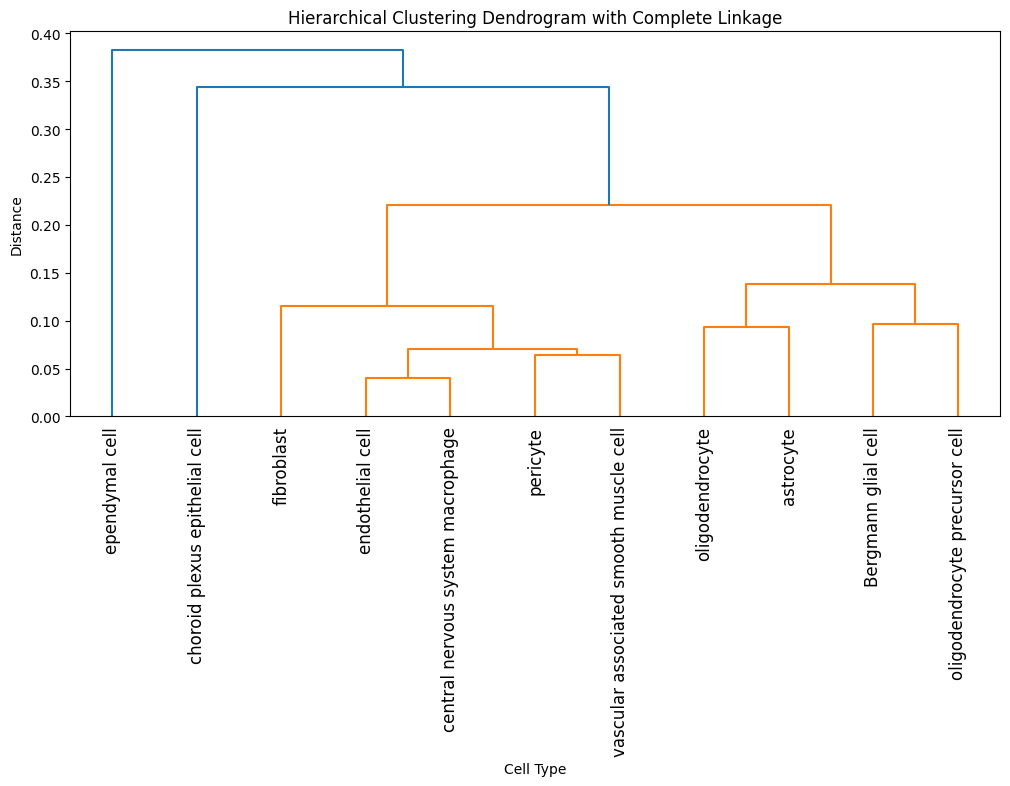

In [53]:
plot_dendrogram(e_dist_agg, cell_types, method='average')
plot_dendrogram(e_dist_agg, cell_types, method='complete')

## Bottleneck

In [54]:
b_dist_arr = np.array([p_dist_both, e_dist_both])
b_dist_agg = np.sum(np.stack([dist/np.linalg.norm(dist, ord=2) for dist in b_dist_arr]), axis=0)

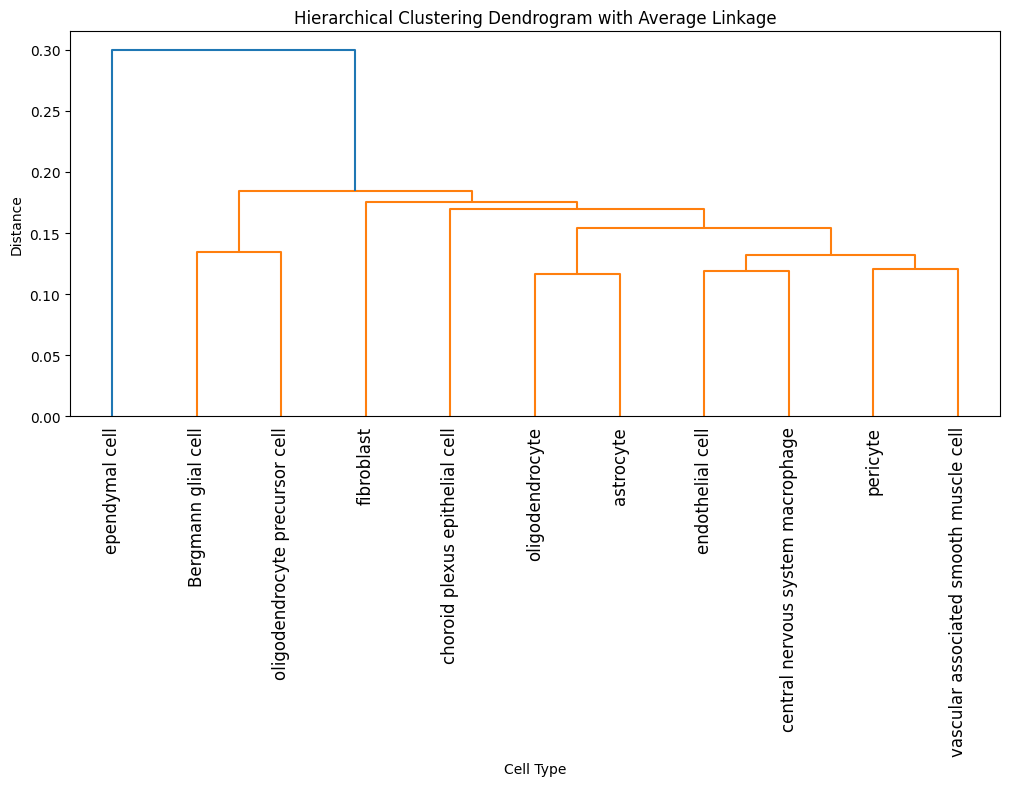

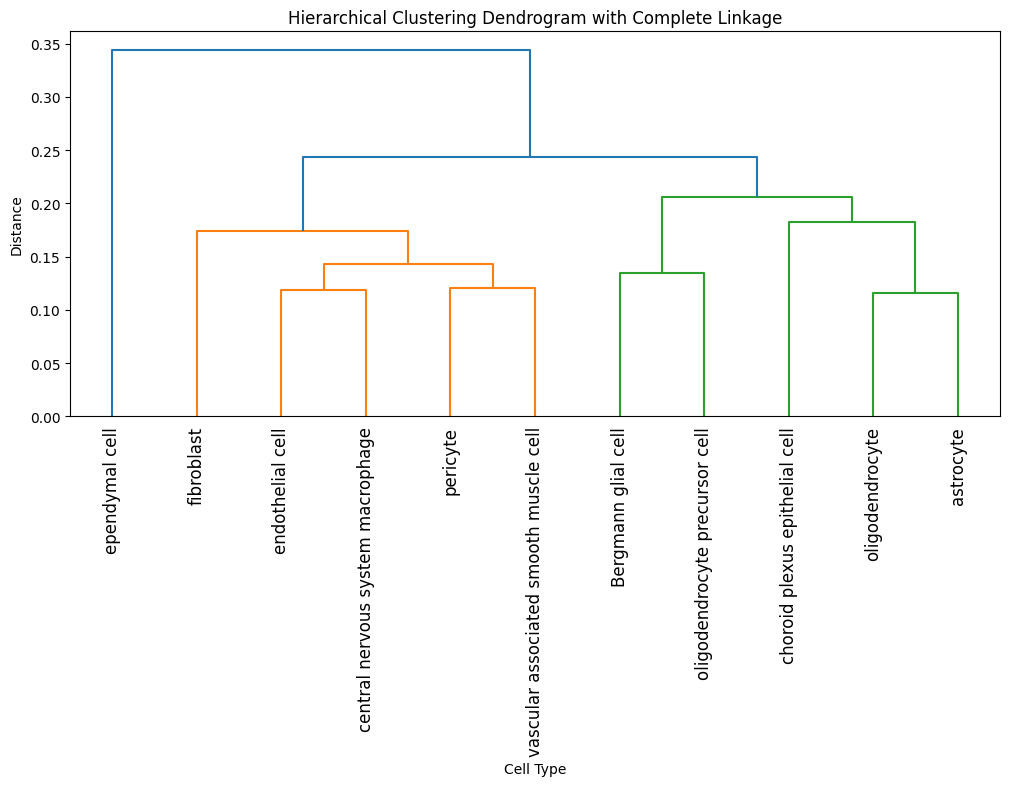

In [55]:
plot_dendrogram(b_dist_agg, cell_types, method='average')
plot_dendrogram(b_dist_agg, cell_types, method='complete')

## Persistence Image

In [56]:
img_dist_arr = np.array([p_norms_pad, e_norms_pad])
img_dist_agg = np.sum(np.stack([dist/np.linalg.norm(dist, ord=2) for dist in img_dist_arr]), axis=0)

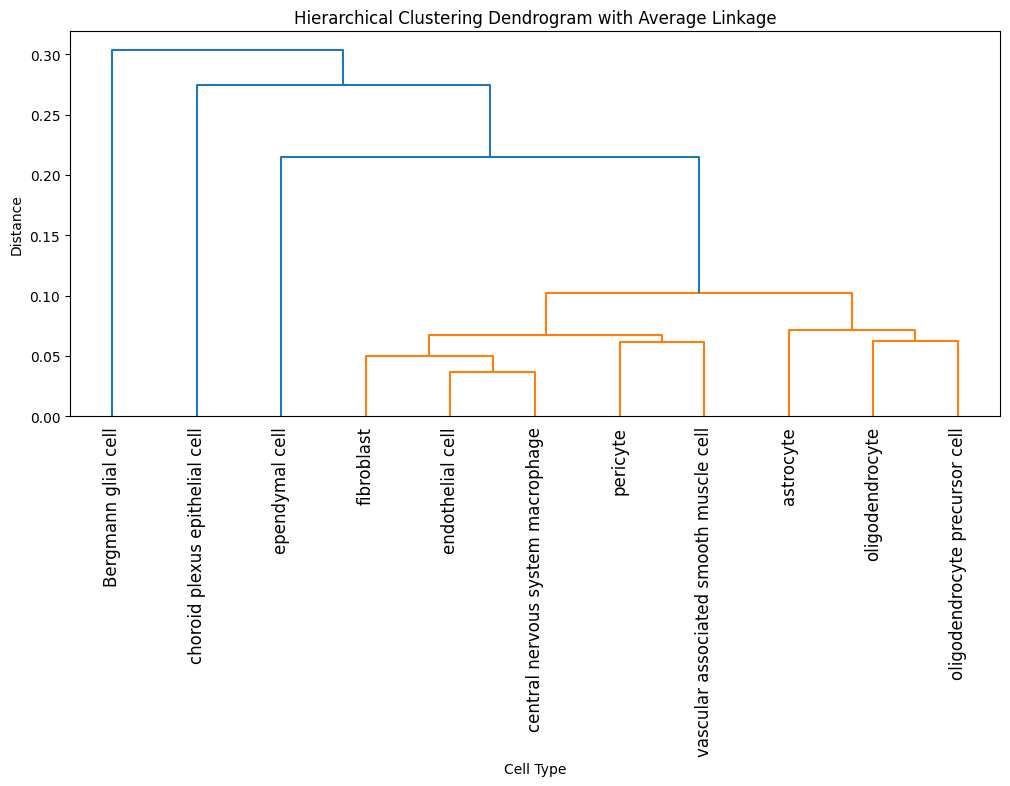

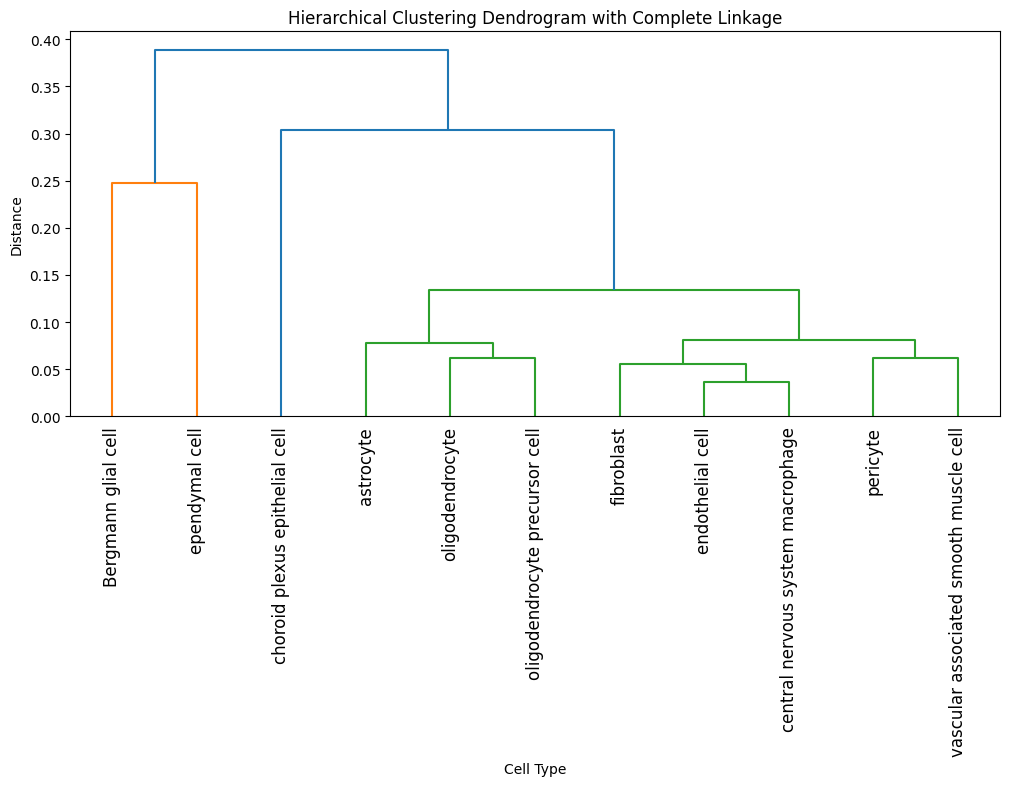

In [57]:
plot_dendrogram(img_dist_agg, cell_types, method='average')
plot_dendrogram(img_dist_agg, cell_types, method='complete')

## All aggregated

In [58]:
all_dist_arr = np.array([p_dist_both, e_dist_both, p_norms_pad, e_norms_pad])
all_dist_agg = np.sum(np.stack([dist/np.linalg.norm(dist, ord=2) for dist in all_dist_arr]), axis=0)

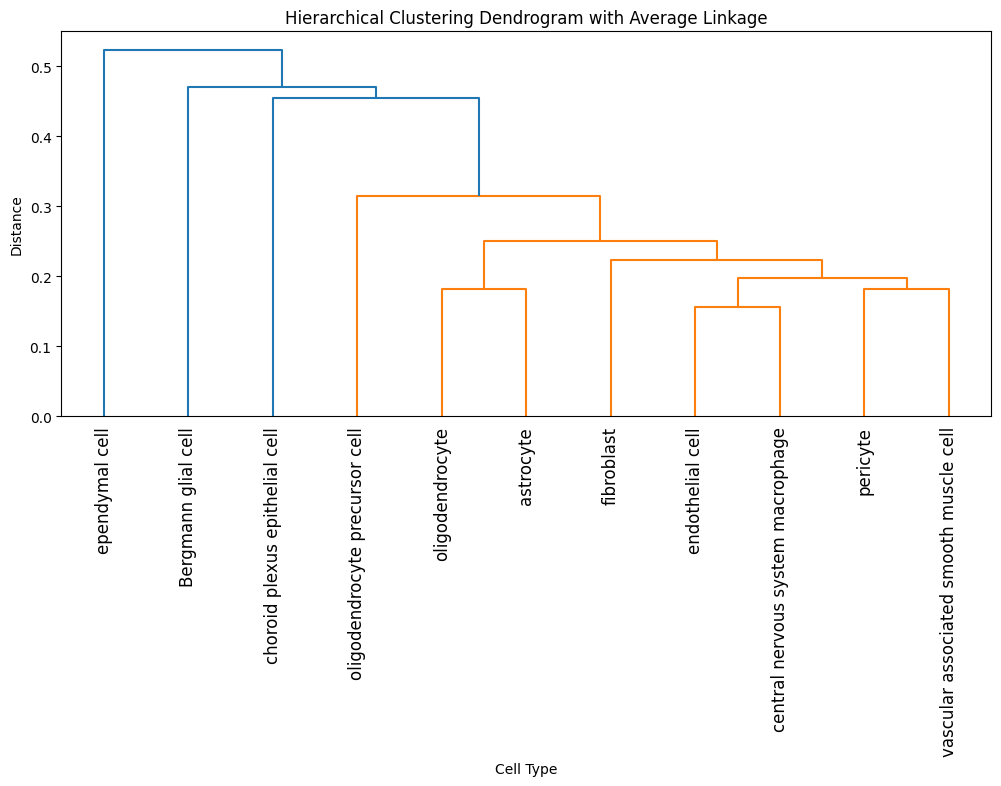

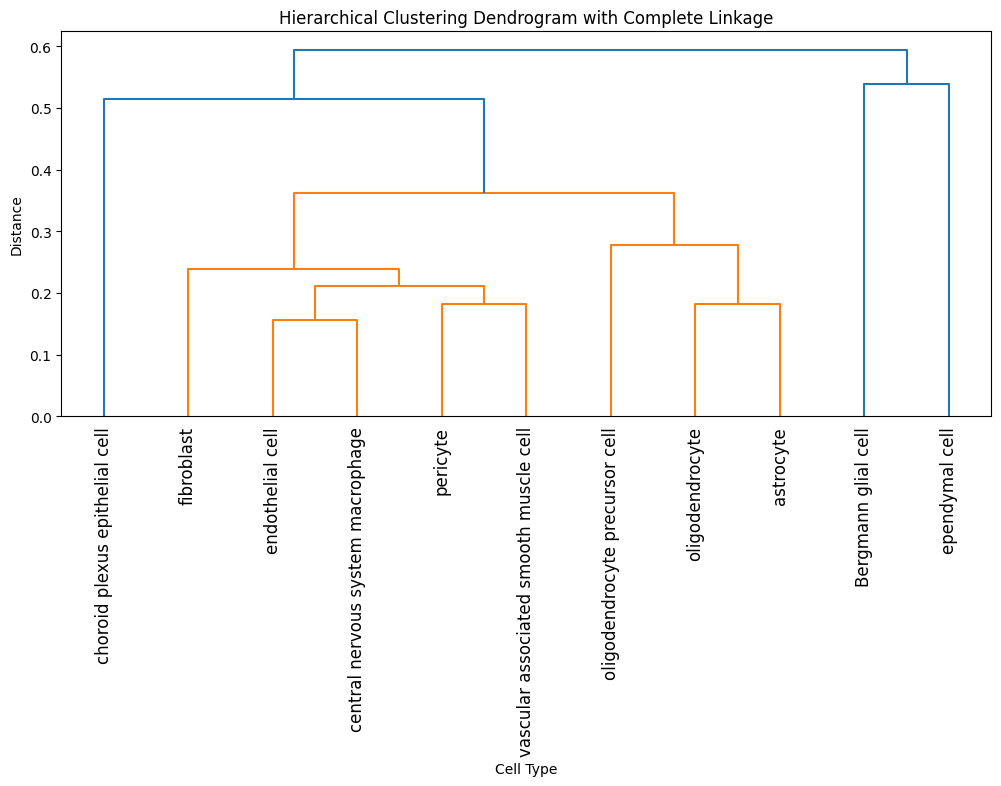

In [59]:
plot_dendrogram(all_dist_agg, cell_types, method='average')
plot_dendrogram(all_dist_agg, cell_types, method='complete')

# Finished! 🎉